# Neural SINDy, v3

In [1]:
# Imports
import numpy as np
import math
import torch
import torch.optim as optim
import torch.nn as nn
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('font', size=20)
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import copy

## Dynamic Simulation Functionality

In [2]:
# Dynamic Simulation Class
class DynamicSim():
  def __init__(self,X0,tf,t0,dt,params):
    self.Xi = X0.astype(float) # Initialize state vector to initial condition
    self.ti = t0 # Initial time
    self.tf = tf # Final time
    self.dt = dt # Time step size
    self.params = params # System parameters

  ############################################

  # The system's equations of motion.
  # This is a placeholder function which
  # can be overwritten for a given dynamical system.
  def f_Eq_of_Motion(self):
    print("Test DynamicSim class.")
    return 0

  ############################################  

  # Simulate the dynamical system:
  def f_Simulate(self):

    self.Xi = self.Xi.astype(float)

    tf = self.tf
    dt = self.dt
    params = self.params

    Nt = int(tf/dt) # Number of time steps
    XN = np.zeros((len(self.Xi),Nt)) # Initialize state vector
    XP = np.zeros((len(self.Xi),Nt)) # Initialize vector of derivatives
    uN = np.zeros(Nt) # Initialize vector of control inputs
    t_vec = np.zeros((1,Nt)) # Initialize vector of times
    XN[:,0] = self.Xi # Initial conditions

    i = 0 # Initialize iteration counter
    # Iterate over time interval:
    for i in np.arange(Nt-1):
        # Update time derivative using the equations of motion
        Xp, uN[i] = self.f_Eq_of_Motion()
        self.Xi += Xp*dt # Update state at ith time step

        XN[:,i+1] = self.Xi # Update state
        XP[:,i] = Xp # Update time derivative
        t_vec[:,i] = self.ti # Update time vector
        i += 1 # Increment counter
        self.ti += dt # Increment timer

        # If system diverges, break out of simulation:
        if np.max(np.abs(XN)) > 1e10:
          break
 
    XP[:,i], uN[i] = self.f_Eq_of_Motion() # Update final derivative and control
    t_vec[:,i] = self.ti # Update time vector

    # Ouput: Nominal state & derivative (only up to (i+1)th entry, in case of divergence)
    return XN[:,0:i+1], XP[:,0:i+1], uN[0:i+1], t_vec[:,0:i+1]

  ############################################

  # Run num_sim number of simulations:
  def f_N_Simulations(self,X0_tot,num_sims):
    
    tf = self.tf
    dt = self.dt
    params = self.params
    dim = np.shape(self.Xi)[0]
    Nt = int(tf/dt) # Number of time steps

    # Initialize arrays to hold data from all simulations:
    XN_tot = np.zeros((dim,Nt*num_sims)) # Initialize state vector
    XP_tot = np.zeros((dim,Nt*num_sims)) # Initialize vector of derivatives
    uN_tot = np.zeros(Nt*num_sims) # Initialize vector of control inputs
    t_vec_tot = np.zeros((1,Nt*num_sims)) # Initialize vector of times

    ct = 0 # Total number of time steps elapsed
    for i in np.arange(num_sims):
      X0 = X0_tot[i] # Get initial condition
      self.Xi = X0.astype(float) # Update initial condition
  
      XN, XP, uN, t_vec = self.f_Simulate() # Run a simulation

      lt = np.shape(t_vec)[1] # Number of time steps in simulation
      ct2 = ct + lt # Compute total number of time steps so far

      # Add simulation results to arrays
      XN_tot[:,ct:ct2] = XN
      XP_tot[:,ct:ct2] = XP
      uN_tot[ct:ct2] = uN
      t_vec_tot[:,ct:ct2] = t_vec
      ct = ct2 # Update total number of time steps so far
    
    return XN_tot, XP_tot, uN_tot, t_vec_tot

In [3]:
# Add Gaussian noise to position and velocity vectors:
def f_Add_Noise(XN,XP,pos_scale=1,vel_scale=10,add_noise=1):
  # Add noise to position and velocity measurements:
  if add_noise == 1:
    pos_noise = np.random.normal(loc=0, scale=pos_scale, size=np.shape(XN))
    vel_noise = np.random.normal(loc=0, scale=vel_scale, size=np.shape(XP))
  else:
    pos_noise = 0
    vel_noise = 0

  return XN+pos_noise, XP+vel_noise

### 2D Nonlinear Damped Oscillator with Sinusoidal Forcing

In [4]:
class Nonlinear_Damped_Osc_2D(DynamicSim):
  def __init__(self,X0,tf,t0,dt,params):
    super(Nonlinear_Damped_Osc_2D, self).__init__(X0,tf,t0,dt,params)

  def f_Eq_of_Motion(self):
    Xi = self.Xi
    w1 = self.params[0]
    w2 = self.params[1]
    w3 = self.params[2]
    w4 = self.params[3]
    A = self.params[4]
    omega = self.params[5]

    u = A*np.sin(omega*self.ti)
    # u2 = (A/2)*np.sin(2*omega*self.ti)

    return np.array([w1*Xi[0]**3 + w2*Xi[1]**3 + u, w3*Xi[0] + w4*Xi[1]]), u

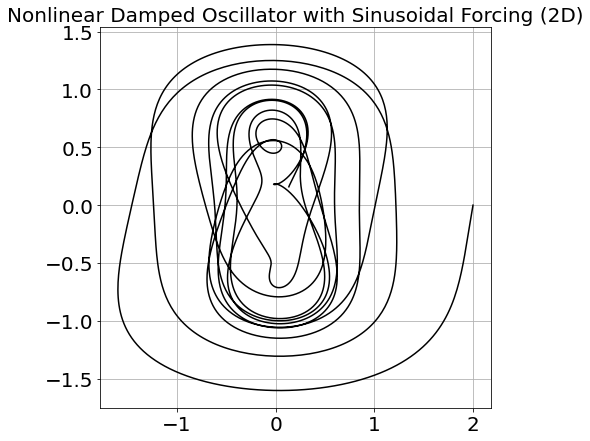

In [5]:
t0 = 0
tf = 50
dt = 0.01
X0 = np.array([2,0])

w1 = -0.1
w2 = 2
w3 = -w2
w4 = w1
A = 0.5
omega = 1
params = np.array([w1,w2,w3,w4,A,omega])

Nonlin_Damped_Osc_2D_1 = Nonlinear_Damped_Osc_2D(X0,tf,t0,dt,params)
XN, XP, uN, t_vec = Nonlin_Damped_Osc_2D_1.f_Simulate()

fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.plot(XN[0], XN[1], '-', color = "black")
ax.set_title('Nonlinear Damped Oscillator with Sinusoidal Forcing (2D)', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid()
plt.show()

### 3D Nonlinear Damped Oscillator with Sinusoidal Forcing

In [6]:
class Nonlinear_Damped_Osc_3D(DynamicSim):
  def __init__(self,X0,tf,t0,dt,params):
    super(Nonlinear_Damped_Osc_3D, self).__init__(X0,tf,t0,dt,params)

  def f_Eq_of_Motion(self):
    Xi = self.Xi
    w1 = self.params[0]
    w2 = self.params[1]
    w3 = self.params[2]
    w4 = self.params[3]
    w5 = self.params[4]
    w6 = self.params[5]
    w7 = self.params[6]
    w8 = self.params[7]
    w9 = self.params[8]
    A = self.params[9]
    omega = self.params[10]

    u = A*np.sin(omega*self.ti)
    # u2 = (A/2)*np.sin(2*omega*self.ti)

    return np.array([w1*Xi[0]**3 + w2*Xi[1]**3 + w3*Xi[2]**3 + u, w4*Xi[0] + w5*Xi[1] + w6*Xi[2], w7*Xi[0] + w8*Xi[1] + w9*Xi[2]]), u

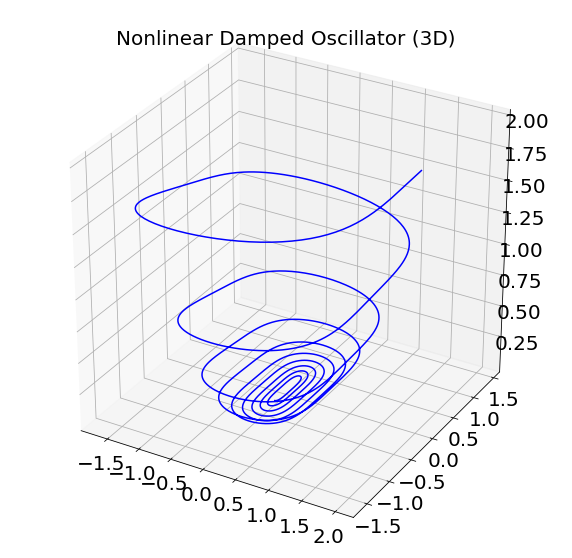

In [7]:
t0 = 0
tf = 50
dt = 0.01
X0 = np.array([2,0, 2])

w1 = -0.1
w2 = 2
w3 = 0
w4 = -w2
w5 = w1
w6 = 0
w7 = -w3
w8 = -w6
w9 = -0.3
A = 0
omega = 1
params = np.array([w1,w2,w3,w4,w5,w6,w7,w8,w9,A,omega])
7
Nonlin_Damped_Osc_3D_1 = Nonlinear_Damped_Osc_3D(X0,tf,t0,dt,params)
XN, XP, uN, t_vec = Nonlin_Damped_Osc_3D_1.f_Simulate()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot3D(XN[0], XN[1], XN[2], 'b')
ax.set_title('Nonlinear Damped Oscillator (3D)', fontsize = 20)
plt.show()

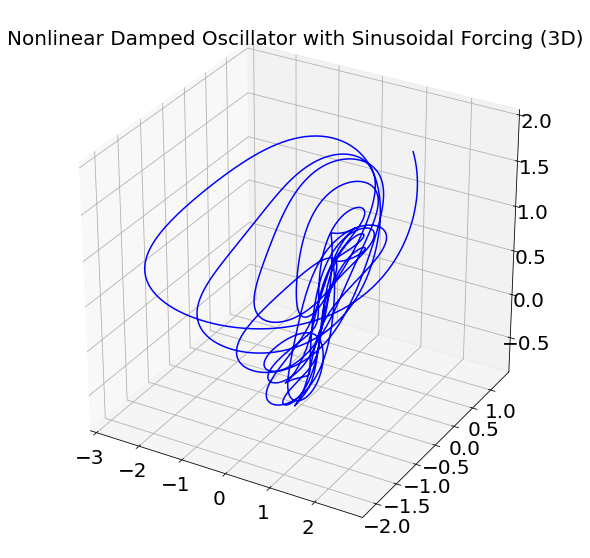

In [8]:
t0 = 0
tf = 50
dt = 0.01
X0 = np.array([2,0, 2])

w1 = -0.1
w2 = 2
w3 = 1
w4 = -w2
w5 = w1
w6 = -0.5
w7 = -w3
w8 = -w6
w9 = -0.3
A = 1
omega = 1
params = np.array([w1,w2,w3,w4,w5,w6,w7,w8,w9,A,omega])
7
Nonlin_Damped_Osc_3D_2 = Nonlinear_Damped_Osc_3D(X0,tf,t0,dt,params)
XN, XP, uN, t_vec = Nonlin_Damped_Osc_3D_2.f_Simulate()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot3D(XN[0], XN[1], XN[2], 'b')
ax.set_title('Nonlinear Damped Oscillator with Sinusoidal Forcing (3D)', fontsize = 20)
plt.show()

### Van der Pol Oscillator with Sinusoidal Forcing:

In [9]:
class Van_der_Pol_Osc(DynamicSim):
  def __init__(self,X0,tf,t0,dt,params):
    super(Van_der_Pol_Osc, self).__init__(X0,tf,t0,dt,params)

  def f_Eq_of_Motion(self):
    Xi = self.Xi
    mu = self.params[0]
    A = self.params[1]
    omega = self.params[2]
    u = A*np.sin(omega*self.ti)
    # u = 0
    # return np.array([mu*(Xi[0] - Xi[0]**3/3 - Xi[1]), Xi[0]/mu]), u
    return np.array([Xi[1],mu*(1-Xi[0]**2)*Xi[1] - Xi[0] + u]), u

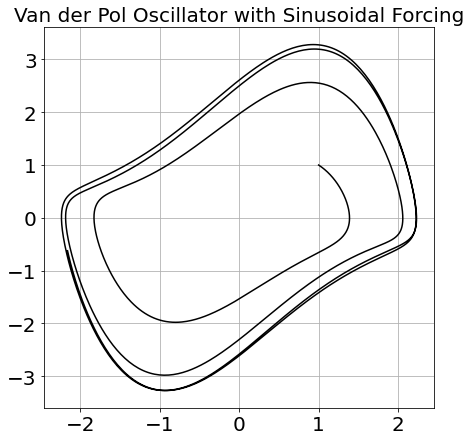

In [10]:
t0 = 0
tf = 25
dt = 0.01
X0 = np.array([1,1])
mu = 1
A = 0.5
omega = 1
params = np.array([mu, A, omega])

Van_der_Pol1 = Van_der_Pol_Osc(X0,tf,t0,dt,params)
XN, XP, uN, t_vec = Van_der_Pol1.f_Simulate()

fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.plot(XN[0], XN[1], '-', color = "black")
ax.set_title('Van der Pol Oscillator with Sinusoidal Forcing', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid()
plt.show()

### Hopf System with Time-Varying Parameters

In [11]:
class Hopf_System(DynamicSim):
  def __init__(self,X0,tf,t0,dt,params):
    super(Hopf_System, self).__init__(X0,tf,t0,dt,params)

  def f_Eq_of_Motion(self):
    Xi = self.Xi
    alpha = self.params[0]
    beta = self.params[1]
    gamma = self.params[2]
    A = self.params[3]
    omega = self.params[4]

    # u = A*np.sin(omega*self.ti)
    u = 0
    
    gamma += A*np.sin(omega*self.ti)

    Xp = np.array([alpha*Xi[0] + beta*Xi[1] - gamma*Xi[0]*(Xi[0]**2 + Xi[1]**2 + u),
                       -beta*Xi[0] + alpha*Xi[1] - gamma*Xi[1]*(Xi[0]**2 +Xi[1]**2)])
    return Xp, u

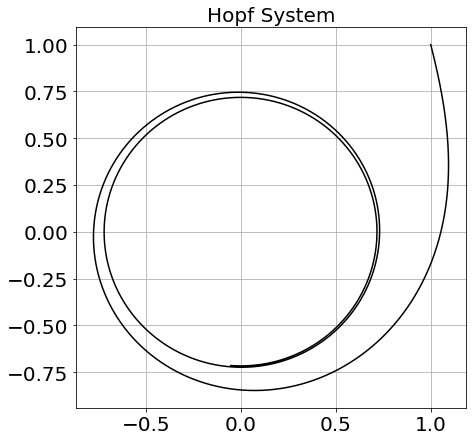

In [12]:
t0 = 0
tf = 15
dt = 0.01
X0 = np.array([1,1])
alpha = 0.2 
beta = 1
gamma = 0.4
A = 0
omega = 1
params = np.array([alpha,beta,gamma, A, omega])

Hopf1 = Hopf_System(X0,tf,t0,dt,params)
XN, XP, uN, t_vec = Hopf1.f_Simulate()

fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.plot(XN[0], XN[1], '-', color = "black")
ax.set_title('Hopf System', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid()
plt.show()

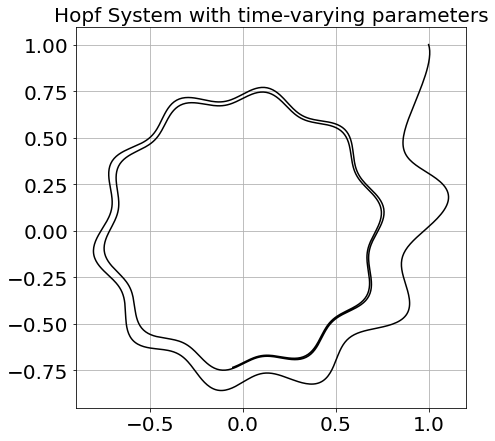

In [13]:
t0 = 0
tf = 15
dt = 0.01
X0 = np.array([1,1])
alpha = 0.2 
beta = 1
gamma = 0.4
A = 1
omega = 10
params = np.array([alpha,beta,gamma, A, omega])

Hopf1 = Hopf_System(X0,tf,t0,dt,params)
XN, XP, uN, t_vec = Hopf1.f_Simulate()

fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.plot(XN[0], XN[1], '-', color = "black")
ax.set_title('Hopf System with time-varying parameters', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid()
plt.show()

### Lorenz System with Sinusoidal Forcing and/or Time-Varying Parameters

In [14]:
# Lorenz System
class Lorenz_System(DynamicSim):
  def __init__(self,X0,tf,t0,dt,params):
    super(Lorenz_System, self).__init__(X0,tf,t0,dt,params)

  def f_Eq_of_Motion(self):
    Xi = self.Xi
    sigma = self.params[0]
    beta = self.params[1]
    rho = self.params[2]
    A = self.params[3]
    omega = self.params[4]
    
    # u = 0
    # u = A*np.sin(omega*self.ti)
    u = A*np.sin(omega*Xi[0])
    # beta += A*np.sin(omega*self.ti)

    return np.array([sigma*(Xi[1]-Xi[0]) + u, Xi[0]*(rho-Xi[2])-Xi[1], Xi[0]*Xi[1]-beta*Xi[2]]), u

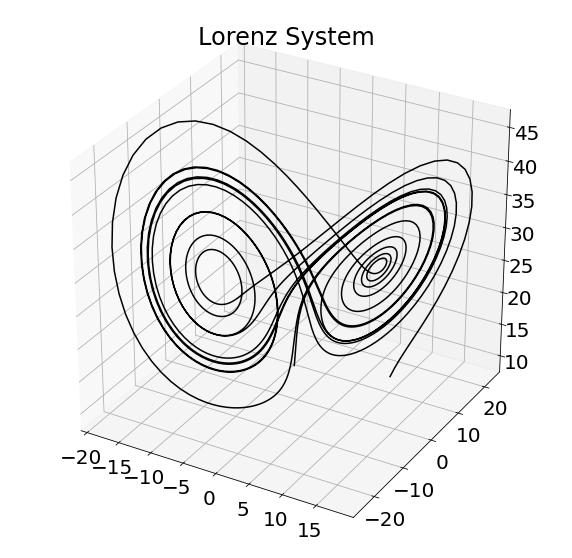

In [15]:
t0 = 0
tf = 15
dt = 0.01
X0 = np.array([10,10,10])
sigma = 10
beta = 8/3
rho = 28
A = 0
omega = 1
params = np.array([sigma,beta,rho,A,omega])

Lorenz1 = Lorenz_System(X0,tf,t0,dt,params)
XN, XP, uN, t_vec = Lorenz1.f_Simulate()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot3D(XN[0], XN[1], XN[2], 'k')
ax.set_title('Lorenz System')
plt.show()

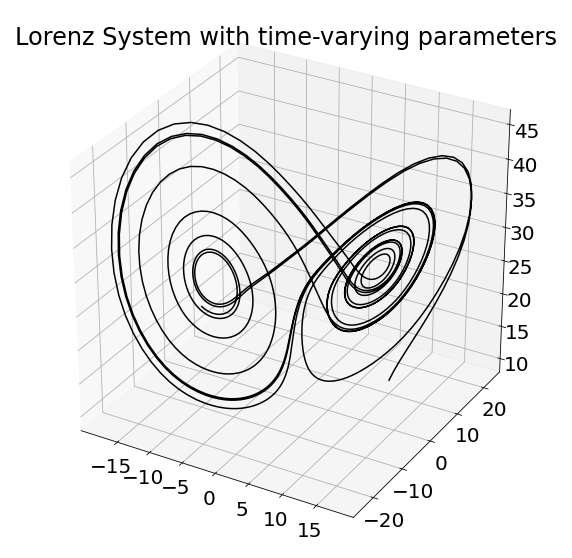

In [16]:
t0 = 0
tf = 15
dt = 0.01
X0 = np.array([10,10,10])
sigma = 10
beta = 8/3
rho = 28
A = 2
omega = 1
params = np.array([sigma,beta,rho,A,omega])

Lorenz2 = Lorenz_System(X0,tf,t0,dt,params)
XN, XP, uN, t_vec = Lorenz2.f_Simulate()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot3D(XN[0], XN[1], XN[2], 'k')
ax.set_title('Lorenz System with time-varying parameters')
plt.show()

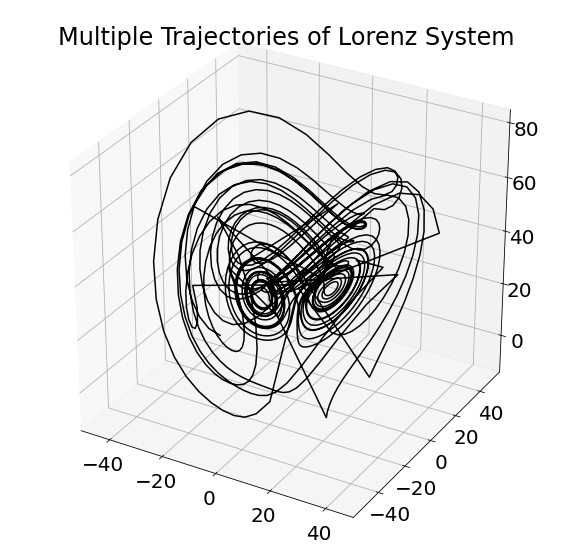

In [17]:
num_sims = 15

X0_tot = []
for i in np.arange(num_sims):
  X0 = np.array([np.random.uniform(-50,50),np.random.uniform(-50,50),np.random.uniform(-20,80)])
  X0_tot.append(X0)

Lorenz1.tf = 2
XN_tot, XP_tot, uN_tot, t_vec_tot = Lorenz1.f_N_Simulations(X0_tot,num_sims)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot3D(XN_tot[0], XN_tot[1], XN_tot[2], 'k')
ax.set_title('Multiple Trajectories of Lorenz System')
plt.show()

### Rocket with PD Control

In [18]:
# Rocket with PD Control:
class PD_Rocket(DynamicSim):
  def __init__(self,X0,tf,t0,dt,params):
    super(PD_Rocket, self).__init__(X0,tf,t0,dt,params)

  # PD Controller:
  def f_PD_Controller(self,k_p=1,k_d=1):
    g = self.params[0]
    T = self.params[1]
    h = self.params[2]
    Nt = int(self.tf/self.dt)
    theta_balance = np.round(math.asin(g/T),5)
    P = k_p*(1-np.exp(-3*self.ti/Nt))*(h-self.Xi[1])/(3*h)
    D = -k_d*self.Xi[3]/5000
    return P + D  + theta_balance # Control

  def f_Eq_of_Motion(self):
    g = self.params[0]
    T = self.params[1]
    h = self.params[2]

    # Update derivative using the equations of motion
    u = self.f_PD_Controller()
    return np.array([self.Xi[2], self.Xi[3], T*np.cos(u), T*np.sin(u) - g]), u # Compute time derivatives

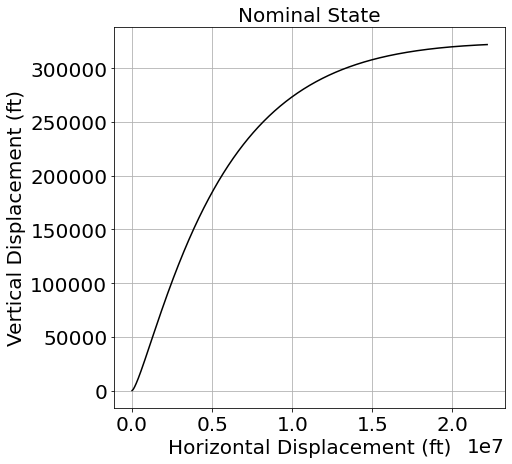

In [19]:
# System Parameters:
g = 32 # Gravitational acceleration (ft/sec^2)
T = 2*g # Constant specific thrust of the rocket
h = 320000 # Final height in ft
params = np.array([g,T,h])
t0 = 0 # Start time (sec)
tf = 900 # Final time (sec)
dt = 1 # Time step (in diff. eq. solver)

# Initial Conditions:
# (zero displacement & velocity)
X0 = np.array([0,0,0,0])

Rocket1 = PD_Rocket(X0,tf,t0,dt,params)

XN, XP, uN, t_vec = Rocket1.f_Simulate()

# Plot of the nominal trajectory vs time:
fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.plot(XN[0], XN[1], '-', color = "black")
ax.set_title('Nominal State', fontsize = 20)
ax.set_xlabel('Horizontal Displacement (ft)', fontsize = 20)
ax.set_ylabel('Vertical Displacement (ft)', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid()
plt.show()

### Cart-Pole with PD Control
http://www.matthewpeterkelly.com/tutorials/cartPole/index.html \\
https://www.ashwinnarayan.com/post/cartpole-dynamics/ \\

In [20]:
class Cart_Pole(DynamicSim):
  def __init__(self,X0,tf,t0,dt,params):
    super(Cart_Pole, self).__init__(X0,tf,t0,dt,params)

  def f_Eq_of_Motion(self):
    Xi = self.Xi
  
    g = self.params[0]
    mc = self.params[1]
    mp = self.params[2]
    L = self.params[3]
    A = self.params[4]
    omega = self.params[5]

    # return np.array([Xi[1],-(g/L)*np.sin(Xi[0])+u]), u # Inverted pendulum

    # u = 1
    # u = A*np.sin(omega*self.ti)
    u = -A*np.arctan(Xi[1]-np.pi)
    # u = -A*np.arctan(Xi[1]-np.pi) - (A/10)*np.arctan(Xi[2])

    # Cart-pole V1:
    a = np.cos(Xi[1])
    c = mc + mp
    d = mp*L*np.cos(Xi[1])
    e = -g*np.sin(Xi[1])
    f = mp*L*Xi[3]**2*np.sin(Xi[1]) + u
    return np.array([Xi[2],Xi[3],(d*e - L*f)/(a*d - L*c), (-c*e + a*f)/(a*d - L*c)]), u

    # # Cart-pole V2 (the two versions are equivalent):
    # a = mc + mp
    # b = mp*L*np.cos(Xi[1])
    # c = mp*L*np.cos(Xi[1])
    # d = mp*L**2

    # vel = np.array([Xi[2],Xi[3]])
    # acc = ((u + mp*L*Xi[3]**2*np.sin(Xi[1]))*np.array([d,-c]) + mp*g*L*np.sin(Xi[1])*np.array([b,-a]))/(a*d-b*c)

    # return np.append(vel,acc), u

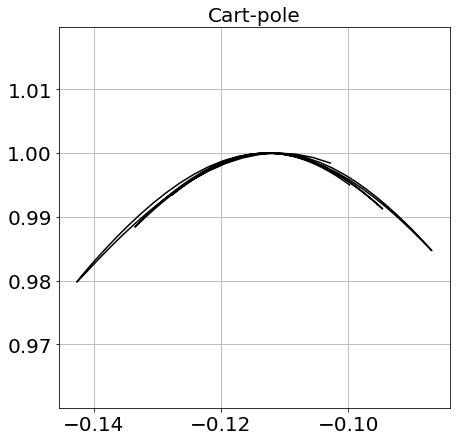

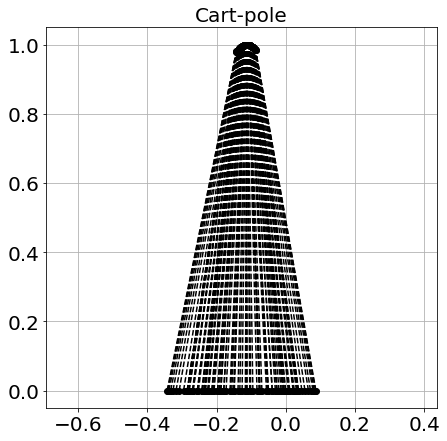

In [21]:
t0 = 0
tf = 2
dt = 0.01
X0 = np.array([0,np.pi+0.1,0,0])
g = 9.8
mc = 1
mp = 1
L = 1
A = 100
omega = 1
params = np.array([g,mc,mp,L,A,omega])

Cart_Pole1 = Cart_Pole(X0,tf,t0,dt,params)
XN, XP, uN, t_vec = Cart_Pole1.f_Simulate()

x = XN[0] + L*np.sin(XN[1])
y = -L*np.cos(XN[1])

fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.plot(x, y, '-', color = "black")
# ax.plot(XN[0],XN[0]*0, '-', color = "blue")
ax.set_title('Cart-pole', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.axis('equal')
plt.grid()
plt.show()

fig, ax = plt.subplots(1,1, figsize = (7,7))
for i in np.arange(len(x)):
  if np.mod(i,2) == 0:
    x_values = [XN[0][i],x[i]]
    y_values = [0,y[i]]
    plt.plot(x_values, y_values, 'ko', linestyle="--")
ax.set_title('Cart-pole', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.axis('equal')
plt.grid()
plt.show()

### Double-pendulum

In [22]:
class Double_Pendulum(DynamicSim):
  def __init__(self,X0,tf,t0,dt,params):
    super(Double_Pendulum, self).__init__(X0,tf,t0,dt,params)

  def f_Eq_of_Motion(self):
    Xi = self.Xi
  
    g = self.params[0]
    m1 = self.params[1]
    m2 = self.params[2]
    L1 = self.params[3]
    L2 = self.params[4]
    A = self.params[5]
    omega = self.params[6]
    
    # u = 0
    u = A*np.sin(omega*self.ti)

    Xp = np.array([Xi[2],
                   Xi[3],
                  (-g*(2*m1 + m2)*np.sin(Xi[0]) - m2*g*np.sin(Xi[0] - 2*Xi[1]) - 2*np.sin(Xi[0] - Xi[1])*m2*(Xi[3]**2*L2 + Xi[2]**2*L1*np.cos(Xi[0] - Xi[1])))/(L1*(2*m1 + m2 - m2*np.cos(2*Xi[0] - 2*Xi[1]))),
                  (2*np.sin(Xi[0] - Xi[1])*(Xi[2]**2*L1*(m1 + m2) + g*(m1 + m2)*np.cos(Xi[0]) + Xi[3]**2*L2*m2*np.cos(Xi[0] - Xi[1])))/(L1*(2*m1 + m2 - m2*np.cos(2*Xi[0] - 2*Xi[1])))])    
    
    return Xp, u

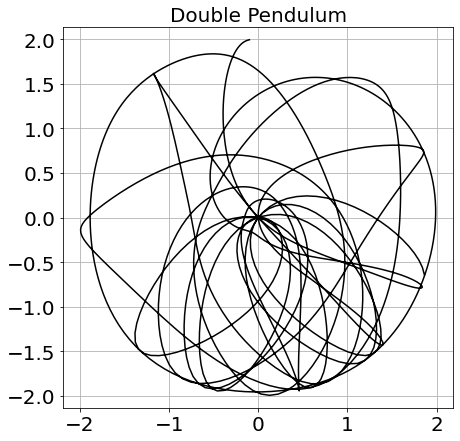

In [23]:
t0 = 0
tf = 15
dt = 0.01
X0 = np.array([np.pi,np.pi+0.1,0,0])
g = 9.8
m1 = 1
m2 = 1
L1 = 1
L2 = 1
A = 0
omega = 10
params = np.array([g,m1,m2,L1,L2,A,omega])

Double_Pend1 = Double_Pendulum(X0,tf,t0,dt,params)
XN, XP, uN, t_vec = Double_Pend1.f_Simulate()

x1 = L1*np.sin(XN[0])
y1 = -L1*np.cos(XN[0])
x2 = x1 + L2*np.sin(XN[1])
y2 = y1 - L2*np.cos(XN[1])

fig, ax = plt.subplots(1,1, figsize = (7,7))
# ax.plot(x1, y1, '-', color = "red")
ax.plot(x2, y2, '-', color = "black")
ax.set_title('Double Pendulum', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.axis('equal')
plt.grid()
plt.show()

### Hopfield network
http://www.scholarpedia.org/article/Hopfield_network


In [24]:
class Hopfield_Network(DynamicSim):
  def __init__(self,X0,tf,t0,dt,params):
    super(Hopfield_Network, self).__init__(X0,tf,t0,dt,params)

  def f_Eq_of_Motion(self):
    n = len(self.Xi)
    Xi = np.reshape(self.Xi,(n,1))
    tau = self.params[0]

    # M = np.random.randint(0, 2, (n, n))
    # # M*(M == M.T)
    # M ^= M.T

    M = np.random.uniform(0, 2, (n, n))
    M = (M + M.T)/2

    g = np.reshape(np.arctan(Xi),(n,1))

    # u = 1
    # U = np.ones((n,1))*u
    
    u = 0
    U = np.random.uniform(0, n, (n,1))
    
    # U = np.zeros((n,1))
    # u  = np.random.randint(0, 2)
    # U[np.random.randint(0,n)] = u

    return np.reshape(-Xi/tau + np.matmul(M,g) + U, n), u

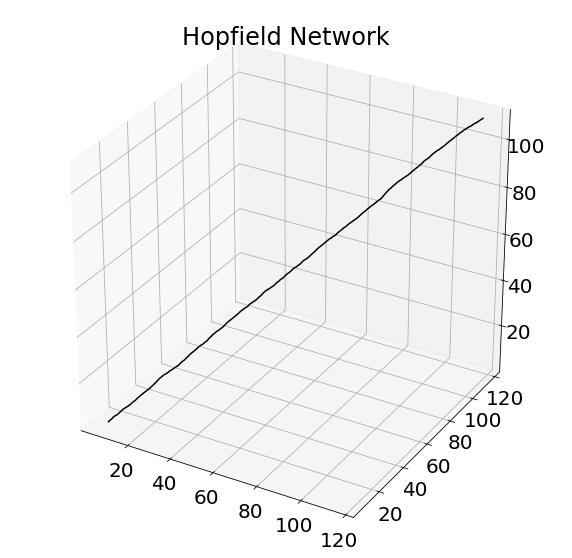

In [25]:
t0 = 0
tf = 2
dt = 0.01
n = 30
tau = 1
# X0 = np.random.randint(0, 2, n)
X0 = np.random.uniform(0, 10, n)

Hopfield_Net1 = Hopfield_Network(X0,tf,t0,dt,params)
XN, XP, uN, t_vec = Hopfield_Net1.f_Simulate()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot3D(XN[0], XN[1], XN[2], 'k')
ax.set_title('Hopfield Network')
plt.show()

### Mean-Field Model of Fluid Flow Past a Cylinder

In [26]:
# Mean Field Model
class Mean_Field(DynamicSim):
  def __init__(self,X0,tf,t0,dt,params):
    super(Mean_Field, self).__init__(X0,tf,t0,dt,params)

  def f_Eq_of_Motion(self):
    Xi = self.Xi
    alpha = self.params[0]
    beta = self.params[1]
    gamma = self.params[2]
    delta = self.params[3]

    u = 0

    Xp = np.array([alpha*Xi[0] - beta*Xi[1] + gamma*Xi[0]*Xi[2],
                   beta*Xi[0] + alpha*Xi[1] + gamma*Xi[1]*Xi[2],
                   -delta*(Xi[2] - Xi[0]**2 - Xi[1]**2)])

    return Xp, u

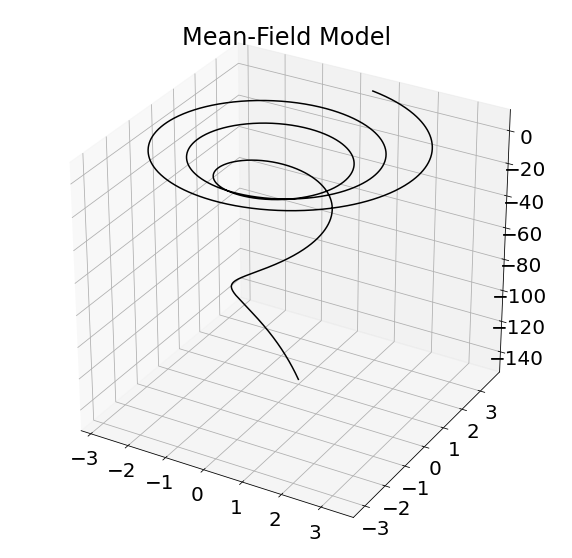

In [27]:
t0 = 0
tf = 25
dt = 0.01
X0 = np.array([0,1,-150])
alpha = 0.05
beta = 1
gamma = 2e-4
delta = 0.3
params = np.array([alpha,beta,gamma,delta])

Mean_Field1 = Mean_Field(X0,tf,t0,dt,params)
XN, XP, uN, t_vec = Mean_Field1.f_Simulate()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot3D(XN[0], XN[1], XN[2], 'k')
ax.set_title('Mean-Field Model')
plt.show()

### Lattice Boltzmann Simulation of Fluid Flow Past a Cylinder (incomplete)
https://medium.com/swlh/create-your-own-lattice-boltzmann-simulation-with-python-8759e8b53b1c

## Neural Network Functionality

### Custom Activations and Layer Types

In [28]:
# Activation Functions:

# Natural-log ReLU
def NLReLU(x):
  return torch.log(F.relu(x)+1)

# 1/x
def Div(x):
  return torch.pow(x,-1)

In [29]:
# Multiplicative Layer
# (Takes two input scalars and multiplies them)
class MultiplicativeLayer(nn.Module):
  def __init__(self):
    super(MultiplicativeLayer, self).__init__()

  def forward(self, inputs):
    # Array to hold output for each element of the batch:
    output = torch.ones(inputs.size()[0],1)
    batch_i = 0 # Batch number
    for t in inputs: # For a sample in the batch
    # Output for this batch is the product of all features:
      output[batch_i] = torch.prod(t)
      batch_i += 1
    return output

In [30]:
# Pairwise Multiplicative Layer
# (Multiplies every pair of inputs and sums them
# Note that there are O(x^2) such pairs, so
# the input layer should not be too large.)
class PairwiseMultiplicativeLayer(nn.Module):
  def __init__(self):
    super(PairwiseMultiplicativeLayer, self).__init__()

  def forward(self, inputs):
    # Array to hold output for each element of the batch:
    # output = torch.zeros(inputs.size()[0],1)
    in_features = inputs.size()[1] # Number of input features
    # Number of pairs = x*(x+1)/2:
    # num_pairs = int(in_features*(in_features+1)/2)
    num_pairs = int(in_features*(in_features-1)/2)
    output = torch.zeros(inputs.size()[0],num_pairs)
    batch_i = 0 # Batch number
    for t in inputs: # For a sample in the batch
      pair_i = 0 # Pair number
      # Loop through all pairs of features:
      # for j in np.arange(in_features):
      for j in np.arange(in_features-1)+1:
        for k in np.arange(in_features-j)+j:
          pair = torch.tensor((t[j],t[k])) # Pair of features
          # Add product of this pair of features to the output:
          # output[batch_i] += self.W[pair_i]*torch.prod(pair)
          output[batch_i,pair_i] = torch.prod(pair)
          pair_i += 1
      batch_i += 1
    return output

In [31]:
# # Power Layer (incomplete)
# # (Takes each component of input vector to a power of a learnable parameter)
# class Power(nn.Module):
#   def __init__(self):
#     super(Power, self).__init__()
#     self.b = torch.nn.Parameter(torch.randn(()))

#   def forward(self, inputs):
#     output = torch.ones(inputs.size()[0],1)
#     i = 0
#     for t in inputs:
#       # output[i] = torch.exp(self.b*torch.log(t))
#       output[i] = torch.pow(inputs,self.b)
#       i += 1
#     return output

In [32]:
# https://tomekkorbak.com/2020/06/26/implementing-attention-in-pytorch/

# # Attention
# class Attention(torch.nn.Module):

#     def __init__(self, encoder_dim: int, decoder_dim: int):
#         super().__init__()
#         self.encoder_dim = encoder_dim
#         self.decoder_dim = decoder_dim

#     def forward(self, 
#         query: torch.Tensor,  # [decoder_dim]
#         values: torch.Tensor, # [seq_length, encoder_dim]
#         ):
#         weights = self._get_weights(query, values) # [seq_length]
#         # weights = torch.nn.functional.softmax(weights, dim=0)
#         return weights @ values  # [encoder_dim]

Reference for building masked layers: https://julianstier.com/posts/2021/06/pruning-neural-networks-with-pytorch/

In [33]:
# Masked Linear Layer
class MaskedLinearLayer(torch.nn.Linear):
    def __init__(self, in_features: int, out_features: int, bias=False, keep_layer_input=False):
        """
        :param in_feature: Number of input features
        :param out_features: Output features in analogy to torch.nn.Linear
        :param bias: Iff each neuron in the layer should have a bias unit as well.
        """
        super().__init__(in_features, out_features, bias)

        self.register_buffer('mask', torch.ones((out_features, in_features), dtype=torch.bool))
        self.keep_layer_input = keep_layer_input
        self.layer_input = None

    def forward(self, input):
        x = input.float()  # In case we get a double-tensor passed, force it to be float for multiplications to work

        # Possibly store the layer input
        if self.keep_layer_input:
            self.layer_input = x.data

        return F.linear(x, self.weight * self.mask, self.bias)

    # # Compute mask
    # def compute_mask(self):
    #   mask = self.mask.detach().numpy() # Convert mask to numpy
    #   weight = self.weight.detach().numpy() # Convert weight array to numpy
    #   mask_idx = np.where(mask == True) # Indices of nonzeros in mask
    #   weight_idx = np.argmin(abs(weight[mask_idx]))
    #   idx = tuple(np.vstack(mask_idx)[:,weight_idx]) # Index of minimum absolute-value weight
    #   self.mask[idx] = False # Set mask term to zero
    #   with torch.no_grad(): # (zeroing out weight isn't differentiable)
    #     self.weight[idx] = 0 # Set weight term to zero

    # Compute mask
    def compute_mask(self,idx):
      self.mask[idx] = False # Set mask term to zero
      with torch.no_grad(): # (zeroing out weight isn't differentiable)
        self.weight[idx] = 0 # Set weight term to zero

### Custom Losses

In [34]:
# L1 loss:
def f_L1_loss(w,l1_weight=1):
  # Get model parameters:
  parameters = []
  for parameter in model.parameters():
    parameters.append(parameter.view(-1))
  return l1_weight*torch.abs(torch.cat(parameters)).sum()

# L2 loss:
def f_L2_loss(w,l2_weight=1):
  # Get model parameters:
  parameters = []
  for parameter in model.parameters():
    parameters.append(parameter.view(-1))
  return l2_weight*torch.square(torch.cat(parameters)).sum()

# Thresholded L1 loss:
def f_Thresholded_L1_loss(model,l1_weight=1):
  # Get model parameters:
  parameters = []
  for parameter in model.parameters():
    parameters.append(parameter.view(-1))
  abs_vals = torch.abs(torch.cat(parameters))
  idx = torch.where(abs_vals > 0)
  threshold = 2*torch.min(abs_vals[idx])*len(idx[0])
  idx2 = torch.where(abs_vals > threshold)
  abs_vals[idx2] = threshold
  return l1_weight*abs_vals.sum()

### Network Architectures

In [35]:
# One-layer Linear Neural Network:
class one_layer_lin_net(torch.nn.Module):

  # Initialize the network and specify input/output dimensions:
  def __init__(self, num_in, num_out):
    super(one_layer_lin_net, self).__init__()
    # self.bn = nn.BatchNorm1d(num_in)
    self.h1 = MaskedLinearLayer(in_features=num_in, out_features=num_out) # Masked linear layer
    # self.layer_norm = nn.LayerNorm(num_in)

    # self.weighted_inputs1 = torch.zeros(num_in*num_out)
    # self.weighted_inputs2 = torch.zeros(num_in*num_out)
    # self.weighted_inputs3 = torch.zeros(num_in*num_out)
    # self.weighted_inputs4 = torch.zeros(num_in*num_out)

  # Build the network:
  def forward(self, inputs):
    a1 = self.h1(inputs) # Linear activation
    # a0 = self.layer_norm(inputs)
    # a1 = self.h1(a0) # Linear activation
    return a1

  # Initialize weights as array of constants:
  def initialize_const(self,init_array,num_in, num_out):
    for param in self.parameters():
      # param.data = nn.parameter.Parameter(torch.zeros_like(param))
      param.data = nn.parameter.Parameter(init_array)

  # def initialize(self):
  #   for m in self.modules():
  #     if isinstance(m, nn.Linear):
  #       nn.init.normal_(m.weight.data,mean=0.0, std=3)
  #       # module.weight.data.normal_(mean=0.0, std=0.1

In [36]:
# Two-layer Linear Neural Network:
class two_layer_lin_net(torch.nn.Module):

  # Initialize the network and specify input/output dimensions:
  def __init__(self, num_in, num_out, w1):
    super(two_layer_lin_net, self).__init__()
    # self.h1 = MaskedLinearLayer(in_features=num_in, out_features=num_out) # Masked linear
    self.weighted_inputs = torch.zeros(num_in*w1 + w1*num_out)

    self.h1 = MaskedLinearLayer(in_features=num_in, out_features=w1) # Masked linear layer
    self.h2 = MaskedLinearLayer(in_features=w1, out_features=num_out) # Masked linear layer
    
  # Build the network:
  def forward(self, inputs):
    a1 = self.h1(inputs) # Linear activation
    a2 = self.h2(a1) # Linear activation
    return a2

  def initialize_const(self,init_array,num_in, num_out):
    for param in self.parameters():
      # param.data = nn.parameter.Parameter(torch.zeros_like(param))
      param.data = nn.parameter.Parameter(init_array)

In [37]:
# Two-layer AC Network:
class two_layer_ac_net(torch.nn.Module):

  # Initialize the network and specify input/output dimensions:
  def __init__(self, num_in, num_out, w1):
    super(two_layer_ac_net, self).__init__()
    # self.h0 = MaskedLinearLayer(in_features=num_in, out_features=num_out) # Masked linear
    # self.weighted_inputs = torch.zeros(num_in*w1 + w1*num_out)

    self.h1 = MaskedLinearLayer(in_features=num_in, out_features=w1) # Masked linear layer
    self.m1 = MultiplicativeLayer() # Multiplicative layer

  # Build the network:
  def forward(self, inputs):
    a1 = self.h1(inputs) # Linear activation
    a2 = self.m1(a1) # Multiplicative layer
    return a2

  def initialize_const(self,init_array,num_in, num_out):
    for param in self.parameters():
      # param.data = nn.parameter.Parameter(torch.zeros_like(param))
      param.data = nn.parameter.Parameter(init_array)

In [38]:
# Two-layer Pairwise AC Network:
class two_layer_pairwise_ac_net(torch.nn.Module):

  # Initialize the network and specify input/output dimensions:
  def __init__(self, num_in, num_out):
    super(two_layer_pairwise_ac_net, self).__init__()

    self.h0 = MaskedLinearLayer(in_features=num_in, out_features=num_out) # Masked linear layer
    self.m1 = PairwiseMultiplicativeLayer() # Multiplicative layer
    # num_pairs = int(num_in*(num_in+1)/2)
    num_pairs = int(num_in*(num_in-1)/2)
    self.h1 = MaskedLinearLayer(in_features=num_pairs, out_features=num_out) # Masked linear layer

  # Build the network:
  def forward(self, inputs):
    a0 = self.h0(inputs) # Residual layer
    a1 = self.m1(inputs) # Multiplicative layer
    a2 = self.h1(a1) # Linear layer
    return a0 + a2

  def initialize_const(self,init_array,num_in, num_out):
    for param in self.parameters():
      # param.data = nn.parameter.Parameter(torch.zeros_like(param))
      param.data = nn.parameter.Parameter(init_array)

In [39]:
# Second-Order Sine + Multiplicative Network:
class second_ord_sin_mult_net(torch.nn.Module):

  # Initialize the network and specify input/output dimensions:
  def __init__(self, num_in, num_out, W):
    super(second_ord_sin_mult_net, self).__init__()
    self.h1 = MaskedLinearLayer(in_features=num_in, out_features=W[0]) # Masked linear layer
    self.m1 = MultiplicativeLayer() # Multiplicative layer
    
    self.h2 = MaskedLinearLayer(in_features=num_in, out_features=W[1]) # Masked linear layer
    self.h3 = MaskedLinearLayer(in_features=num_in, out_features=W[1]) # Masked linear layer
    self.h4 = MaskedLinearLayer(in_features=num_in, out_features=W[1]) # Masked linear layer
    self.h5 = MaskedLinearLayer(in_features=num_in, out_features=W[1]) # Masked linear layer
    self.h6 = MaskedLinearLayer(in_features=num_in, out_features=W[1]) # Masked linear layer

    self.h7 = MaskedLinearLayer(in_features=W[1], out_features=W[1])
    self.h8 = MaskedLinearLayer(in_features=W[1], out_features=W[1])
    self.h9 = MaskedLinearLayer(in_features=W[1], out_features=W[1])
    self.h10 = MaskedLinearLayer(in_features=W[1], out_features=W[1])
    self.h11 = MaskedLinearLayer(in_features=W[1], out_features=W[1])

  # Build the network:
  def forward(self, inputs):
    a1 = self.h1(inputs) # Linear activation
    
    a2 = torch.sin(self.h2(inputs))
    a3 = torch.sin(self.h3(inputs))
    a4 = torch.sin(self.h4(inputs))
    a5 = torch.sin(self.h5(inputs))
    a6 = torch.sin(self.h6(inputs))

    a7 = self.h7(a2)
    a8 = self.h8(a3)
    a9 = self.h9(a4)
    a10 = self.h10(a5)
    a11 = self.h11(a6)

    a12 = self.m1(a1) # Multiplicative layer

    return a12 + a7 + a8 + a9 + a10 + a11

  def initialize_const(self,init_array,num_in, num_out):
    for param in self.parameters():
      # param.data = nn.parameter.Parameter(torch.zeros_like(param))
      param.data = nn.parameter.Parameter(init_array)

In [40]:
# Depth-4 Sine + Multiplicative Network:
class depth_four_sin_mult_net(torch.nn.Module):

  # Initialize the network and specify input/output dimensions:
  def __init__(self, num_in, num_out, W):
    super(depth_four_sin_mult_net, self).__init__()

    self.hA0_0 = MaskedLinearLayer(in_features=num_in, out_features=W[1]) # Masked linear layer
    self.m0 = MultiplicativeLayer() # Multiplicative layer
    
    self.hB0_0 = MaskedLinearLayer(in_features=num_in, out_features=W[1]) # Masked linear layer
    self.hB1_0 = MaskedLinearLayer(in_features=num_in, out_features=W[1]) # Masked linear layer
    self.hB2_0 = MaskedLinearLayer(in_features=num_in, out_features=W[1]) # Masked linear layer

    self.hB0_1 = MaskedLinearLayer(in_features=1, out_features=1) # Masked linear layer
    self.hB1_1 = MaskedLinearLayer(in_features=1, out_features=1) # Masked linear layer
    self.hB2_1 = MaskedLinearLayer(in_features=1, out_features=1) # Masked linear layer`

    self.hC0_0 = MaskedLinearLayer(in_features=num_in, out_features=W[0])
    # self.hC0_3 = MaskedLinearLayer(in_features=1, out_features=1)
    self.m1 = MultiplicativeLayer() # Multiplicative layer

    self.hD0_0 = MaskedLinearLayer(in_features=num_in, out_features=W[0]) # Masked linear layer
    # self.hD0_3 = MaskedLinearLayer(in_features=1, out_features=1)
    self.m2 = MultiplicativeLayer() # Multiplicative layer

    self.hE0_0 = MaskedLinearLayer(in_features=num_in, out_features=W[0]) # Masked linear layer
    self.m3 = MultiplicativeLayer() # Multiplicative layer

    self.hF0_1 = MaskedLinearLayer(in_features=W[0], out_features=W[1]) # Masked linear layer

    self.m4 = MultiplicativeLayer() # Multiplicative layer
    self.m5 = MultiplicativeLayer() # Multiplicative layer

    self.hG0_0 = MaskedLinearLayer(in_features=num_in, out_features=W[2]) # Masked linear layer
    self.m6 = MultiplicativeLayer() # Multiplicative layer

  # Build the network:
  def forward(self, inputs):
    aA0_0 = self.hA0_0(inputs) # Linear activation
    
    aB0_0 = torch.sin(self.hB0_0(inputs))
    aB1_0 = torch.sin(self.hB1_0(inputs))
    aB2_0 = torch.sin(self.hB2_0(inputs))

    aC0_0 = self.hC0_0(inputs) # Linear activation
    aC0_1 = self.m1(aC0_0) # Multiplicative layer
    aC0_2 = torch.sin(aC0_1)

    aD0_0 = self.hD0_0(inputs) # Linear activation
    aD0_1 = self.m2(aD0_0) # Multiplicative layer
    aD0_2 = torch.sin(aD0_1)

    aE0_0 = self.hE0_0(inputs) # Linear activation
    aE0_1 = self.m3(aE0_0) # Multiplicative layer

    aC0_2_aD0_2 = torch.hstack((aC0_2,aD0_2))
    aF0_1 = self.hF0_1(aC0_2_aD0_2) # Linear activation

    aG0_0 = self.hG0_0(inputs) # Linear activation

    aO1 = self.m0(aA0_0) # Multiplicative layer
    aO2 = self.hB0_1(aB0_0)
    aO3 = self.hB1_1(aB1_0)
    aO4 = self.hB2_1(aB2_0)
    aO5 = aF0_1
    aO6 = self.m4(torch.hstack((aO1,aF0_1)))
    aO7 = self.m5(aC0_2_aD0_2)
    aO8 = torch.sin(aF0_1)
    aO9 = self.m6(aG0_0) 

    return aO1 + aO2 + aO3 + aO4 + aO5 + aO6 + aO7 + aO8 + aO9

  def initialize_const(self,init_array,num_in, num_out):
    for param in self.parameters():
      # param.data = nn.parameter.Parameter(torch.zeros_like(param))
      param.data = nn.parameter.Parameter(init_array)

### Weight Pruning Functionality

In [41]:
# Get second-smallest number in an array
def second_smallest(numbers):
    m1 = m2 = float('inf')
    for x in numbers:
        if x <= m1:
            m1, m2 = x, m1
        elif x < m2:
            m2 = x
    return m2

In [42]:
# Get list of linear layers
def f_get_linear_layers(model):
  linear_layers = []
  for layer in model.children():
    if(type(layer)==MaskedLinearLayer):
      linear_layers.append(layer)
  return linear_layers

# linear_layers = f_get_linear_layers(model)
# for i in linear_layers:
#   print(i.weight)

In [43]:
# # Select the layer from which to prune
# # (the layer containng the weight with the smallest norm):
# def f_layer_to_prune(model):
#   # Get model parameters and store them in W:
#   W = []
#   for param in model.parameters():
#     W.append(param.data.cpu().detach().numpy())

#   min_weights_per_layer = [] # Array of minimum weight in each layer
#   for w_layer_i_t in W:
#     w_layer_i = abs(np.array(w_layer_i_t)) # Get absolute value of weights for each layer and convert to numpy
#     num_nonzero = np.sum(w_layer_i>0) # Number of nonzero weights in given layer
#     # If there is a nonzero weight in this layer:
#     # if num_nonzero > 1:
#     if num_nonzero > 0:
#       # Append the minimum absolute-value weight in the layer to min_weights_per_layer
#       min_weights_per_layer.append(np.min(w_layer_i[np.where(w_layer_i>0)]))
#     else:
#       # Else, append np.Infinity
#       min_weights_per_layer.append(np.Infinity)

#   # if np.min(min_weights_per_layer) == np.Infinity:
#   if second_smallest(min_weights_per_layer) == np.Infinity:
#     # If every layer has 0 connections, the second smallest element of nonzero_weights is np.Infinity
#     layer_to_prune = np.Infinity # Return np.Infinity, as a stopping condition (don't prune anything)
#   else:
#     # Else, return the index of the layer containing the minimum absolute-value weight
#     layer_to_prune  = np.argmin(np.array(min_weights_per_layer))

#   return layer_to_prune # Return layer containing minimum weight

In [44]:
# Find layer and weight index of the weight with the smallest L1 norm:
def f_Prune_by_L1(model):
  # Get model parameters and store them in W:
  W = []
  for param in model.parameters():
    W.append(param.data.cpu().detach().numpy())

  min_weights_per_layer = [] # Array of minimum weight in each layer
  for w_layer_i_t in W:
    w_layer_i = abs(np.array(w_layer_i_t)) # Get absolute value of weights for each layer and convert to numpy
    num_nonzero = np.sum(w_layer_i>0) # Number of nonzero weights in given layer
    # If there is a nonzero weight in this layer:
    # if num_nonzero > 1:
    if num_nonzero > 0:
      # Append the minimum absolute-value weight in the layer to min_weights_per_layer
      min_weights_per_layer.append(np.min(w_layer_i[np.where(w_layer_i>0)]))
    else:
      # Else, append np.Infinity
      min_weights_per_layer.append(np.Infinity)

  # if np.min(min_weights_per_layer) == np.Infinity:
  if second_smallest(min_weights_per_layer) == np.Infinity:
    # If every layer has 0 connections, the second smallest element of nonzero_weights is np.Infinity
    layer_idx = np.Infinity # Return np.Infinity, as a stopping condition (don't prune anything)
  else:
    # Else, return the index of the layer containing the minimum absolute-value weight
    layer_idx = np.argmin(np.array(min_weights_per_layer))
  
  prune_layer = f_get_linear_layers(model)[layer_idx]
  mask = prune_layer.mask.detach().numpy() # Convert mask to numpy
  weight = prune_layer.weight.detach().numpy() # Convert weight array to numpy
  mask_idx = np.where(mask == True) # Indices of nonzeros in mask
  weight_idx = np.argmin(abs(weight[mask_idx]))
  weight_idx = tuple(np.vstack(mask_idx)[:,weight_idx]) # Index of minimum absolute-value weight

  return layer_idx, weight_idx # Return layer containing minimum weight

In [45]:
# Stop training the model and trigger pruning:
def f_trigger_pruning(mean_losses,min_log_mean_loss,epochs_no_improve,n_epochs_stop=10,epoch_dec=0.995):
  log_mean_loss = np.log(mean_losses) # Log of the mean loss for each training epoch
  # If the log-mean loss has decreased by at least a factor of epoch_dec:
  if log_mean_loss <= epoch_dec*min_log_mean_loss:
    epochs_no_improve = 0 # Reset counter of epochs without improvement
    min_log_mean_loss = log_mean_loss # Update the min log-mean loss
  else:
    epochs_no_improve += 1 # Increment the counter of epochs without improvement

  # If n_epochs_stop have elapsed without improvement:
  if epochs_no_improve == n_epochs_stop:
    trigger_prune = True # Set early-stop indicator to True
  else:
    trigger_prune = False # Set early-stop indicator to False
  
  return epochs_no_improve, min_log_mean_loss, trigger_prune

In [46]:
# Get test loss
def f_test_loss(model,loss,train_loader):
  tot_loss = 0
  # Iterate through the data:
  for batch_idx, (cur_x, cur_y) in enumerate(train_loader):

    output = model.forward(cur_x) # Propagate forward through network
    tot_loss += loss(output, cur_y) # Compute loss at current iteration

  return tot_loss/(batch_idx+1) # Return average test loss per batch

# Compare the outputs of two neural net models
def f_compare_models(model1,model2,loss,train_loader):
  tot_loss = 0
  # Iterate through the data:
  for batch_idx, (cur_x, cur_y) in enumerate(train_loader):

    output1 = model1.forward(cur_x) # Propagate forward through network 1
    output2 = model2.forward(cur_x) # Propagate forward through network 2
    tot_loss += loss(output1, output2) # Compute loss at current iteration
    
  return tot_loss/(batch_idx+1) # Return average loss per batch

# Test pruned model against ground truth
def f_test_pruned_model(pruned_model,loss,train_loader):
  tot_loss = 0
  # Iterate through the data:
  for batch_idx, (cur_x, cur_y) in enumerate(train_loader):

    output = pruned_model.forward(cur_x) # Propagate forward through network
    tot_loss += loss(output, cur_y) # Compute loss at current iteration
    
  return tot_loss/(batch_idx+1)

# V2: Prune the edge that, when pruned, results in the highest loss
# (The original version of this function pruned the edge with the least
# effect on the output of the network)
def f_Prune_by_Effect(model):
  loss_every_layer = [] # Array to hold losses due to all edge prunings
  modelB = copy.deepcopy(model) # Make a copy of the neural network
  linear_layers = f_get_linear_layers(modelB) # Get the linear layers of model B

  for layer in linear_layers:
    loss_per_layer = [] # Array to hold all losses for this layer
    mask = layer.mask.detach().numpy() # Get mask
    indices = np.where(mask>0) # Indices where mask is nonzero
    if np.shape(indices)[1] > 0: # If there is more than one unpruned edge in this layer
      for i in np.arange(len(indices[0])): # For every edge in the layer
        layer.mask[indices[0][i],indices[1][i]] = 0 # Drop the ith edge
        # loss_i = f_test_loss(modelB,loss,train_loader).detach().numpy()
        # loss_i = f_compare_models(model,modelB,loss,train_loader).detach().numpy()
        
        # Test the pruned model against ground truth:
        loss_i = f_test_pruned_model(modelB,loss,train_loader).detach().numpy()
        loss_per_layer.append(loss_i) # Append loss to array
        # modelB = copy.deepcopy(model)
        layer.mask[indices[0][i],indices[1][i]] = 1 # Reset the ith edge to value 1
    else:
      # If there are no unpruned edges, set the loss for this layer to np.Infinity:
      loss_per_layer.append(np.Infinity)

    loss_per_layer = np.array(loss_per_layer) # Conver to numpy array
    # idx = np.argmin(loss_per_layer)
    # Append array of losses for this layer to loss_every_layer:
    loss_every_layer.append(loss_per_layer)

  # Convert loss_every_layer to dtype object
  # so that we can iterate through the array:
  loss_every_layer = np.array(loss_every_layer,dtype='object')
  # Append min losses for each layer to array:
  min_layer_losses = []
  for layer_losses in loss_every_layer:
    min_layer_losses.append(np.min(layer_losses))

  # If the min loss is np.Infinity, set layer_idx and weight_idx to np.Infinity
  # This will cause pruning to stop
  if np.min(np.concatenate(loss_every_layer)) == np.Infinity:
    layer_idx = np.Infinity
    weight_idx = np.Infinity
  else:
    # Get the index of the layer with min loss:
    layer_idx = np.argmin(min_layer_losses)
    # Get the index of the edge with min loss in this layer:
    nonzero_idx = np.argmin(loss_every_layer[layer_idx])

    print('layer_idx=',layer_idx) # Print index of layer with min loss
    print('nonzero_idx=',nonzero_idx) # Print index of min-loss edge in this layer
    print('min loss=',min(loss_every_layer[layer_idx])) # Print min loss

    layer = linear_layers[layer_idx] # Layer with min loss
    mask = layer.mask.detach().numpy() # Mask for this layer
    indices = np.where(mask>0) # Nonzero indices
    print("mask=",mask)
    print("indices=",indices)
    # Index of the minimum-loss weight:
    weight_idx = tuple((indices[0][nonzero_idx],indices[1][nonzero_idx]))

  return layer_idx, weight_idx

# losses, epoch_losses = f_train(model,losses,loss,train_loader,opt) # Train the model for an epoch
# mean_loss = sum(epoch_losses)/len(epoch_losses) # Get mean loss for the epoch
# mean_losses.append(mean_loss) # Append mean epoch loss to array
# modelB.h1.mask[indices] = 0
# modelB.h1.mask.detach().numpy()

# linear_layers = f_get_linear_layers(model)
# # i = 0
# # for layer in linear_layers:
# linear_layers[0].mask

# linear_layers

In [47]:
# loss_every_layer = []
# modelB = copy.deepcopy(model)
# linear_layers = f_get_linear_layers(modelB)

# loss_per_layer = []
# mask = layer.mask.detach().numpy()
# indices = np.where(mask>0)

# for layer in linear_layers:
#   loss_per_layer = []
#   mask = layer.mask.detach().numpy()
#   print(mask)
#   indices = np.where(mask>0)
#   print("indices",indices)
#   print(np.shape(indices)[1])
#   if np.shape(indices)[1] > 0:
#     for i in np.arange(len(indices[0])):
#       layer.mask[indices[0][i],indices[1][i]] = 0
#       loss_i = f_compare_models(model,modelB,loss,train_loader).detach().numpy()
#       loss_per_layer.append(loss_i)
#       # modelB = copy.deepcopy(model)
#       layer.mask[indices[0][i],indices[1][i]] = 1
#   else:
#     loss_per_layer.append(np.Infinity)

#   loss_per_layer = np.array(loss_per_layer)
#   # idx = np.argmin(loss_per_layer)
#   loss_every_layer.append(loss_per_layer)

# print(loss_per_layer)
# loss_every_layer = np.array(loss_every_layer,dtype='object')
# print(loss_every_layer)
# min_layer_losses = []
# for layer_losses in loss_every_layer:
#   min_layer_losses.append(np.min(layer_losses))
# layer_idx = np.argmin(min_layer_losses)
# weight_idx = np.argmin(loss_every_layer[layer_idx])
# weight_idx
# layer_idx

# # np.shape(indices)

# np.min(np.concatenate(loss_every_layer))

# # if np.min(loss_every_layer) == np.Infinity:
# #   layer_idx = np.Infinity

 ### Training Functionality

In [48]:
# Train the model:
def f_train(model,losses,loss,train_loader,optimizer):
  model.train()
  epoch_losses = [] # Array to hold losses for this epoch

  # model.weighted_inputs1 = 0
  # model.weighted_inputs2 = 0
  # model.weighted_inputs3 = 0
  # model.weighted_inputs4 = 0
  # Iterate through the data:
  for batch_idx, (cur_x, cur_y) in enumerate(train_loader):

    optimizer.zero_grad() # Zero out gradients
    output = model.forward(cur_x) # Propagate forward through network
    cur_loss = loss(output, cur_y) # Compute loss at current iteration
    
    # cur_loss += f_L1_loss(model,l1_weight=1) # Add L1 loss to loss function
    # cur_loss += f_Thresholded_L1_loss(model,l1_weight=1) # Add Thresholded L1 loss to loss function

    # parameters = []
    # for parameter in model.parameters():
    #     parameters.append(parameter.view(-1))
    # model.weighted_inputs1 += torch.sum(abs(cur_x*torch.cat(parameters)),axis=0)
    # model.weighted_inputs2 += torch.sum(abs(cur_y - cur_x*torch.cat(parameters)),axis=0)
    # model.weighted_inputs3 += torch.sum(abs(cur_y - (output - cur_x*torch.cat(parameters))-abs(cur_y - output)),axis=0)
    # model.weighted_inputs4 += torch.sum(abs(cur_y) - abs(cur_y - cur_x*model.h1.mask),axis=0)

    cur_loss.backward() # Backprop
    optimizer.step() # Step of optimizer
    losses.append(cur_loss.cpu().detach().numpy()) # Append cur_loss to array of losses
    epoch_losses.append(cur_loss.cpu().detach().numpy()) # Append cur_loss to array of epoch losses

  return losses, epoch_losses

In [49]:
# Compile data into format suitable for neural network training in Pytorch:
def f_Training_Data(XN,XP,dim,train_batch_sz=10):

  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  # Convert to torch tensors:
  train_data = torch.from_numpy(XN.T).float().to(device) # as torch.float32
  train_labels = torch.from_numpy(np.reshape(XP[dim],(len(XP[dim]),1))).float().to(device)

  # Create dataset from tensors with matching first dimension
  # Samples will be drawn from the first dimension
  train_dataset = TensorDataset(train_data, train_labels)

  # Create a data loader from the dataset
  # Type of sampling and batch size are specified at this step
  train_loader = DataLoader(train_dataset, batch_size=train_batch_sz, shuffle=False)

  # Create an iterator on the training loader
  # (this is just to test the size of x_train and y_train)
  cur_x, cur_y = next(iter(train_loader))
  print(cur_x.size()) # x_train for current iteration
  print(cur_y.size()) # y_train for current iteration

  return train_loader

In [50]:
# Display model weights:
def f_display_weights(model):

  # weighted_inputs1 = model.weighted_inputs1.detach().numpy()/1501
  # weighted_inputs2 = model.weighted_inputs2.detach().numpy()/1501
  # weighted_inputs3 = model.weighted_inputs3.detach().numpy()/1501
  # weighted_inputs4 = model.weighted_inputs4.detach().numpy()/1501
  # contrb = max(abs(weighted_inputs)) - abs(weighted_inputs)

  # print("weight:",model.h1.weight)
  # print("bias:",model.h1.bias)
  # print("mask:",model.h1.mask)

  linear_layers = f_get_linear_layers(model)
  i = 0
  for layer in linear_layers:
    print("Layer:",i)
    print("weight:",layer.weight)
    print("bias:",layer.bias)
    print("mask:",layer.mask)
    i+=1
    
  # fig, ax = plt.subplots(figsize=(10,10))
  # ax.set_title('Norms')
  # ax1 = ax.twinx()
  # ax2 = ax1.twinx()
  # ax3 = ax2.twinx()
  # ax4 = ax3.twinx()
  # ax.plot(np.abs(W[0][0]),'blue')
  # ax.scatter(np.arange(len(W[0][0])),np.abs(W[0][0]))
  # ax1.plot(weighted_inputs1,'red')
  # ax1.scatter(np.arange(len(weighted_inputs1)),weighted_inputs1)
  # ax2.plot(weighted_inputs2,'green')
  # ax2.scatter(np.arange(len(weighted_inputs2)),weighted_inputs2)
  # ax3.plot(weighted_inputs3,'orange')
  # ax3.scatter(np.arange(len(weighted_inputs3)),weighted_inputs3)
  # ax4.plot(weighted_inputs4,'pink')
  # ax4.scatter(np.arange(len(weighted_inputs4)),weighted_inputs4)
  # plt.grid()
  # plt.show()

  # We want (for Lorenz system):
  # x1 = [-sigma sigma 0 0 0 0 0 0 0 0]
  # x2 = [rho -1 0 0 0 0 0 -1 0 0]
  # x3 = [0 0 -beta 0 0 0 1 0 0 0]
  # where sigma=10,beta=2.666,rho=28

In [51]:
# # Compile data into format suitable for neural network training in Pytorch:
# def f_Training_Data_Multi(XN_tot,XP_tot,dim,trial,train_batch_sz=10):

#   device = 'cuda' if torch.cuda.is_available() else 'cpu'

#   XN = XN_tot[trial]
#   XP = XP_tot[trial]

#   # Convert to torch tensors:
#   train_data = torch.from_numpy(XN.T).float().to(device) # as torch.float32
#   train_labels = torch.from_numpy(np.reshape(XP[dim],(len(XP[dim]),1))).float().to(device)

#   # Create dataset from tensors with matching first dimension
#   # Samples will be drawn from the first dimension
#   train_dataset = TensorDataset(train_data, train_labels)

#   # Create a data loader from the dataset
#   # Type of sampling and batch size are specified at this step
#   train_loader = DataLoader(train_dataset, batch_size=train_batch_sz, shuffle=False)

#   # Create an iterator on the training loader
#   # (this is just to test the size of x_train and y_train)
#   cur_x, cur_y = next(iter(train_loader))
#   print(cur_x.size()) # x_train for current iteration
#   print(cur_y.size()) # y_train for current iteration

#   return train_loader

In [52]:
# # This function trains the neural network model until it nears convergence.
# # It then prunes the weight with the minimum norm and trains the pruned model.
# # Note that the pruned model is NOT trained from scratch.
# # Rather, it uses the weights of the unpruned model in the hope of speeding up training.
# # We continue to train and prune models until there is only one nonzero weight per layer.
# def f_Train_Model(train_loader,XN_2,XP_2,dim,model,loss,opt,w,max_epochs=500,lr=2e-3,n_epochs_stop=10,epoch_dec=0.995,num_to_prune=1,plot_every=1):

#   losses = [] # Array of training losses per iteration
#   mean_losses = [] # Array of mean training losses per epoch

#   device = 'cuda' if torch.cuda.is_available() else 'cpu'

#   trigger_prune = False # Indicator for whether to stop training and trigger pruning
#   stop_training = False # Indicator for whether to break out of the training loop
#   epochs_no_improve = 0 # Number of epochs without log-mean loss improving
#   min_log_mean_loss = np.Infinity # Initialize min of log-mean loss to np.Infinity
#   plot_counter = 0 # Initialize counter for when to plot
#   # Train for a maxmium of max_epochs:
#   for epoch in np.arange(max_epochs)+1:

#     losses, epoch_losses = f_train(model,losses,loss,train_loader,opt) # Train the model for an epoch
#     mean_loss = sum(epoch_losses)/len(epoch_losses) # Get mean loss for the epoch
#     mean_losses.append(mean_loss) # Append mean epoch loss to array

#     # Determine whether to trigger pruning:
#     epochs_no_improve, min_log_mean_loss, trigger_prune = f_trigger_pruning(mean_loss,min_log_mean_loss,epochs_no_improve,n_epochs_stop,epoch_dec)

#     if np.mod(epoch,100) == 0:
#       print("Epoch:", epoch) # Print epoch

#     if trigger_prune == False:
#       pass
#     # If pruning is triggered:
#     else:
#       # Reset min_log_mean_loss to np.Infinity so that the pruned model will
#       # only compare its history of losses to itself and not to previous models:
#       min_log_mean_loss = np.Infinity
#       epochs_no_improve = 0 # Reset epochs_no_improve

#       print("Epoch:", epoch) # Print epoch
#       # print("Iteration:", len(losses)) # Print iteration
#       f_display_weights(model) # Display model weights
#       # print("Weighted Inputs:", weighted_inputs)

#       # If enough prunings have elapsed, plot labels and predictions: 
#       if np.mod(plot_counter,plot_every) == 0:
#         test_labels = torch.from_numpy(np.reshape(XP_2[dim],(len(XP_2[dim]),1))).float().to(device) # Get test labels
#         labels_hat = model(torch.from_numpy(XN_2.T).float().to(device)).cpu().detach().numpy() # Get predictions

#         # lr *= 0.99 # Every time we prune, decrease the learning rate???? Probably not a good idea.
#         opt = torch.optim.Adam(model.parameters(), lr=lr) # Reset optimizer (to clear momentum terms)

#         # Plot labels and predictions:
#         plt.plot(test_labels,'orange')
#         plt.plot(labels_hat,'k--')
#         plt.legend(["Ground Truth", "Prediction"], loc ="lower right")
#         plt.grid()
#         plt.show()

#       # Prune network:
#       # (num_to_prune is the number of weights to prune every time pruning is triggered)
#       for prune_i in np.arange(num_to_prune):
#         plot_counter += 1
#         # If network is fully pruned, indicate that training can be stopped
#         if w == []: # If the network has one layer
#           # If pruning is not complete:
#           if sum(model.h1.mask[0]) > 1:
#             model.h1.compute_mask() # Compute a new mask
#           # If pruning is complete:
#           else:
#             stop_training = True
#         else: # If the network has more than one layer
#           # prune_layer = f_layer_to_prune(model) # Pick the layer to prune next
#           layer_idx, weight_idx = f_Prune_by_L1(model)
#           # If pruning is complete (all layers have a single connection):
#           if layer_idx == np.Infinity:
#             stop_training = True # Set stop_training indicator to True
#           # If pruning is not complete:
#           else:
#             # Compute a new mask:
#             linear_layers = f_get_linear_layers(model)
#             (linear_layers[layer_idx]).compute_mask(weight_idx)

#             # (list(model.children())[layer_idx]).compute_mask()

#         # If the model has been fully pruned, stop training:
#         if stop_training == True:
#           break
#         else:
#           pass
#       # If the model has been fully pruned, stop training:
#       if stop_training == True:
#         break
#       else:
#         pass

#   # print("FINAL MODEL:")
#   # f_display_weights(model) # Display model weights

#   # test_labels = torch.from_numpy(np.reshape(XP_2[dim],(len(XP_2[dim]),1))).float().to(device) # Get test labels
#   # labels_hat = model(torch.from_numpy(XN_2.T).float().to(device)).cpu().detach().numpy() # Get predictions

#   # # Plot labels and predictions:
#   # plt.plot(test_labels,'orange')
#   # plt.plot(labels_hat,'k--')
#   # plt.legend(["Ground Truth", "Prediction"], loc ="lower right")
#   # plt.grid()
#   # plt.show()

#   return losses, mean_losses

In [53]:
# This function trains the neural network model until it nears convergence.
# It then prunes the weight with the minimum norm and trains the pruned model.
# Note that the pruned model is NOT trained from scratch.
# Rather, it uses the weights of the unpruned model in the hope of speeding up training.
# We continue to train and prune models until there is only one nonzero weight per layer.
def f_Train_Model(train_loader,XN_2,XP_2,dim,model,loss,opt,w,max_epochs=500,lr=2e-3,n_epochs_stop=10,epoch_dec=0.995,num_to_prune=1,plot_every=1):

  losses = [] # Array of training losses per iteration
  mean_losses = [] # Array of mean training losses per epoch

  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  layer_idx = 0
  trigger_prune = False # Indicator for whether to stop training and trigger pruning
  stop_training = False # Indicator for whether to break out of the training loop
  epochs_no_improve = 0 # Number of epochs without log-mean loss improving
  min_log_mean_loss = np.Infinity # Initialize min of log-mean loss to np.Infinity
  plot_counter = 0 # Initialize counter for when to plot
  # Train for a maxmium of max_epochs:
  for epoch in np.arange(max_epochs)+1:

    losses, epoch_losses = f_train(model,losses,loss,train_loader,opt) # Train the model for an epoch
    mean_loss = sum(epoch_losses)/len(epoch_losses) # Get mean loss for the epoch
    mean_losses.append(mean_loss) # Append mean epoch loss to array

    # Determine whether to trigger pruning:
    epochs_no_improve, min_log_mean_loss, trigger_prune = f_trigger_pruning(mean_loss,min_log_mean_loss,epochs_no_improve,n_epochs_stop,epoch_dec)

    if np.mod(epoch,100) == 0:
      print("Epoch:", epoch) # Print epoch

    if trigger_prune == False:
      pass
    # If pruning is triggered:
    else:
      # Reset min_log_mean_loss to np.Infinity so that the pruned model will
      # only compare its history of losses to itself and not to previous models:
      min_log_mean_loss = np.Infinity
      epochs_no_improve = 0 # Reset epochs_no_improve

      print("Epoch:", epoch) # Print epoch
      # print("Iteration:", len(losses)) # Print iteration
      f_display_weights(model) # Display model weights

      # If enough prunings have elapsed, plot labels and predictions: 
      if np.mod(plot_counter,plot_every) == 0:
        test_labels = torch.from_numpy(np.reshape(XP_2[dim],(len(XP_2[dim]),1))).float().to(device) # Get test labels
        labels_hat = model(torch.from_numpy(XN_2.T).float().to(device)).cpu().detach().numpy() # Get predictions

        # lr *= 0.99 # Every time we prune, decrease the learning rate???? Probably not a good idea.
        opt = torch.optim.Adam(model.parameters(), lr=lr) # Reset optimizer (to clear momentum terms)

        # Plot labels and predictions:
        plt.plot(test_labels,'orange')
        plt.plot(labels_hat,'k--')
        plt.legend(["Ground Truth", "Prediction"], loc ="lower right")
        plt.grid()
        plt.show()

      # Prune network:
      for prune_i in np.arange(num_to_prune):
        plot_counter += 1
        # If network is fully pruned, indicate that training can be stopped
        # layer_idx, weight_idx = f_Prune_by_L1(model) # Prune weight with min L1 norm
        # Prune weight which, when removed, moves the model output the least from the correct output:
        layer_idx, weight_idx = f_Prune_by_Effect(model)
        if layer_idx == np.Infinity:
          break
        linear_layers = f_get_linear_layers(model)
        (linear_layers[layer_idx]).compute_mask(weight_idx)

    if layer_idx == np.Infinity:
      break

  return losses, mean_losses

In [54]:
# General plotting function:
def f_Plot(input,xlabel='Iteration',ylabel='Loss',title='Training Loss',color="black"):
  plt.plot(input, '-', color = color)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid()
  plt.show()

## Experiments

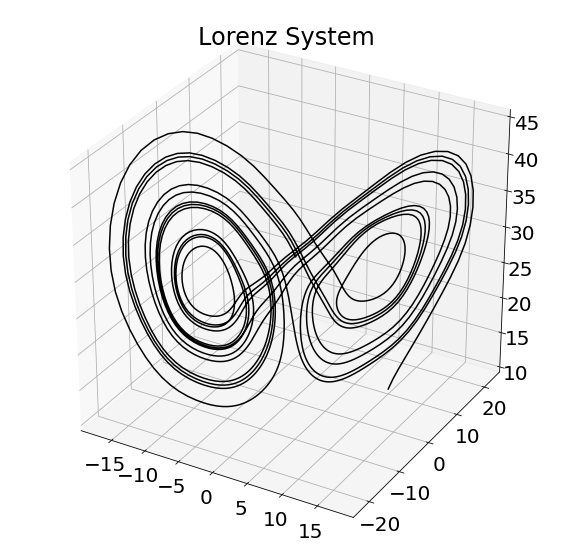

In [55]:
# Run the dynamic model:
t0 = 0
tf = 15
dt = 0.01
X0 = np.array([10,10,10])
sigma = 10
beta = 8/3
rho = 28
A = 10
omega = 1
params = np.array([sigma,beta,rho,A,omega])

# DynamicSim = DynamicSim(X0,tf,t0,dt,params)
Lorenz1 = Lorenz_System(X0,tf,t0,dt,params)
XN, XP, uN, t_vec = Lorenz1.f_Simulate()

# Get testing data
X0_2 = np.array([-30,-30,50])
Lorenz1.Xi = X0_2
Lorenz1.ti = t0
XN_2, XP_2, uN_2, t_vec_2 = Lorenz1.f_Simulate()

XN_noisy, XP_noisy = f_Add_Noise(XN,XP,pos_scale=1,vel_scale=10)
XN_noisy_t = np.concatenate((XN_noisy,t_vec))

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot3D(XN[0], XN[1], XN[2], 'k')
ax.set_title('Lorenz System')
plt.show()

### One-layer model

In [56]:
# # Run the dynamic model:
# t0 = 0
# tf = 15
# dt = 0.01
# X0 = np.array([10,10,10])
# sigma = 10
# beta = 8/3
# rho = 28
# A = 0
# omega = 1
# params = np.array([sigma,beta,rho,A,omega])

# # DynamicSim = DynamicSim(X0,tf,t0,dt,params)
# Lorenz1 = Lorenz_System(X0,tf,t0,dt,params)
# XN, XP, uN, t_vec = Lorenz1.f_Simulate()

# # Get testing data
# X0_2 = np.array([-30,-30,50])
# Lorenz1.Xi = X0_2
# Lorenz1.ti = t0
# XN_2, XP_2, uN_2, t_vec_2 = Lorenz1.f_Simulate()

# # Every second-order term:
# X_second_order = np.column_stack((XN[0]*0+1,XN[0],XN[1],XN[2],XN[0]**2,XN[1]**2,XN[2]**2,XN[0]*XN[1],XN[0]*XN[2],XN[1]*XN[2])).T
# X_second_order_2 = np.column_stack((XN_2[0]*0+1,XN_2[0],XN_2[1],XN_2[2],XN_2[0]**2,XN_2[1]**2,XN_2[2]**2,XN_2[0]*XN_2[1],XN_2[0]*XN_2[2],XN_2[1]*XN_2[2])).T

# # Every second-order term:
# # X_second_order = np.column_stack((XN[0],XN[1],XN[2],XN[0],XN[1],XN[2],XN[0],XN[1],XN[2],XN[0]**2,XN[1]**2,XN[2]**2,XN[0]*XN[1],XN[0]*XN[2],XN[1]*XN[2],XN[0]*0+1,XN[0]**2,XN[1]**2,XN[2]**2,XN[0]*XN[1],XN[0]*XN[2],XN[1]*XN[2],XN[0]*0+1,XN[0]**2,XN[1]**2,XN[2]**2,XN[0]*XN[1],XN[0]*XN[2],XN[1]*XN[2],XN[0]*0+1)).T
# # X_second_order_2 = np.column_stack((XN_2[0],XN_2[1],XN_2[2],XN_2[0],XN_2[1],XN_2[2],XN_2[0],XN_2[1],XN_2[2],XN_2[0]**2,XN_2[1]**2,XN_2[2]**2,XN_2[0]*XN_2[1],XN_2[0]*XN_2[2],XN_2[1]*XN_2[2],XN_2[0]*0+1,XN_2[0]**2,XN_2[1]**2,XN_2[2]**2,XN_2[0]*XN_2[1],XN_2[0]*XN_2[2],XN_2[1]*XN_2[2],XN_2[0]*0+1,XN_2[0]**2,XN_2[1]**2,XN_2[2]**2,XN_2[0]*XN_2[1],XN_2[0]*XN_2[2],XN_2[1]*XN_2[2],XN_2[0]*0+1)).T

# dim = 0 # Dimension of XP to learn
# num_in = len(X_second_order) # Number of in dimension
# num_out = 1 # Number of out dimensions
# lr = 2e-3 # Learning rate
# w1 = [] # Size of hidden layers
# max_epochs = 2000 # Maximum number of training epochs
# train_batch_sz = 10 # Training batch size

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = one_layer_lin_net(num_in, num_out).to(device) # One-layer linear neural network

# # # Test what happens when we initialize from the correct solution:
# # init_array = torch.zeros(num_in)
# # init_array[1] = -0.1
# # init_array[2] = 0.1
# # init_array[8] = -0.1
# # init_array[9] = 0.1bat
# # model.initialize_const(init_array, num_in, num_out)
# # f_display_weights(model)
# # test_labels = torch.from_numpy(np.reshape(XP_2[dim],(len(XP_2[dim]),1))).float().to(device) # Get test labels
# # labels_hat = model(torch.from_numpy(X_second_order_2.T).float().to(device)).cpu().detach().numpy() # Get predictions
# # # Plot labels and predictions:
# # plt.plot(test_labels,'orange')
# # plt.plot(labels_hat,'k--')
# # plt.legend(["Ground Truth", "Prediction"], loc ="lower right")
# # plt.grid()
# # plt.show()

# loss = nn.MSELoss(reduction='mean') # Mean squared error loss
# opt = torch.optim.Adam(model.parameters(), lr=lr) # Optimizer

# opt.zero_grad() # Zero out gradients (SHOULD NOT NEED THIS)

# train_loader = f_Training_Data(X_second_order,XP,dim=dim,train_batch_sz=train_batch_sz) # Load data

# losses, mean_losses = f_Train_Model(train_loader,X_second_order_2,XP_2,dim=dim,model=model,loss=loss,opt=opt,w=w1,max_epochs=max_epochs,lr=lr) # Train model

# f_Plot(losses) # Plot loss per iteration
# f_Plot(np.log(mean_losses),xlabel='Epoch',ylabel='Log of Mean Loss per Epoch',title='Log Mean Loss') # Plot log-mean loss per epoch

# # f_display_weights(model,weighted_inputs)

In [57]:
# #  f_display_weights(model)

# parameters = []
# for parameter in model.parameters():
#     parameters.append(parameter.view(-1))
# torch.cat(parameters)

# for batch_idx, (cur_x, cur_y) in enumerate(train_loader):
#   print(cur_x.size())
#   print(cur_x)

# abs(model.weighted_inputs.detach().numpy()[0])


### Two-layer model

In [58]:
# # Run the dynamic model:
# t0 = 0
# tf = 15
# dt = 0.01
# X0 = np.array([10,10,10])
# sigma = 10
# beta = 8/3
# rho = 28
# A = 0
# omega = 1
# params = np.array([sigma,beta,rho,A,omega])

# # DynamicSim = DynamicSim(X0,tf,t0,dt,params)
# Lorenz1 = Lorenz_System(X0,tf,t0,dt,params)
# XN, XP, uN, t_vec = Lorenz1.f_Simulate()

# # Get testing data
# X0_2 = np.array([-30,-30,50])
# Lorenz1.Xi = X0_2
# Lorenz1.ti = t0
# XN_2, XP_2, uN_2, t_vec_2 = Lorenz1.f_Simulate()

# XN_noisy, XP_noisy = f_Add_Noise(XN,XP,pos_scale=1,vel_scale=10)
# XN_noisy_t = np.concatenate((XN_noisy,t_vec))

# # # Every second-order term:
# # X_second_order = np.column_stack((XN[0]*0+1,XN[0],XN[1],XN[2],XN[0]**2,XN[1]**2,XN[2]**2,XN[0]*XN[1],XN[0]*XN[2],XN[1]*XN[2])).T
# # X_second_order_2 = np.column_stack((XN_2[0]*0+1,XN_2[0],XN_2[1],XN_2[2],XN_2[0]**2,XN_2[1]**2,XN_2[2]**2,XN_2[0]*XN_2[1],XN_2[0]*XN_2[2],XN_2[1]*XN_2[2])).T

# X_second_order = np.column_stack((XN[0]*0+1,XN[0],XN[1],XN[2],XN[0],XN[1],XN[2],XN[0],XN[1],XN[2],XN[0]**2,XN[1]**2,XN[2]**2,XN[0]*XN[1],XN[0]*XN[2],XN[1]*XN[2],XN[0]*0+1,XN[0]**2,XN[1]**2,XN[2]**2,XN[0]*XN[1],XN[0]*XN[2],XN[1]*XN[2],XN[0]*0+1,XN[0]**2,XN[1]**2,XN[2]**2,XN[0]*XN[1],XN[0]*XN[2],XN[1]*XN[2])).T
# X_second_order_2 = np.column_stack((XN_2[0]*0+1,XN_2[0],XN_2[1],XN_2[2],XN_2[0],XN_2[1],XN_2[2],XN_2[0],XN_2[1],XN_2[2],XN_2[0]**2,XN_2[1]**2,XN_2[2]**2,XN_2[0]*XN_2[1],XN_2[0]*XN_2[2],XN_2[1]*XN_2[2],XN_2[0]*0+1,XN_2[0]**2,XN_2[1]**2,XN_2[2]**2,XN_2[0]*XN_2[1],XN_2[0]*XN_2[2],XN_2[1]*XN_2[2],XN_2[0]*0+1,XN_2[0]**2,XN_2[1]**2,XN_2[2]**2,XN_2[0]*XN_2[1],XN_2[0]*XN_2[2],XN_2[1]*XN_2[2])).T

# dim = 0 # Dimension of XP to learn
# num_in = len(X_second_order) # Number of in dimension
# num_out = 1 # Number of out dimensions
# lr = 2e-3 # Learning rate
# w1 = 1 # Size of hidden layers
# max_epochs = 1000 # Maximum number of training epochs

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = two_layer_lin_net(num_in, num_out, w1).to(device) # Two-layer linear neural network
# model.initialize()

# loss = nn.MSELoss(reduction='mean') # Mean squared error loss
# opt = torch.optim.Adam(model.parameters(), lr=lr) # Optimizer

# train_loader = f_Training_Data(X_second_order,XP,dim=dim) # Load data

# losses, mean_losses = f_Train_Model(train_loader,X_second_order_2,XP_2,dim=dim,model=model,loss=loss,opt=opt,w=w1,max_epochs=max_epochs,lr=lr) # Train model

# f_Plot(losses) # Plot loss per iteration
# f_Plot(np.log(mean_losses),xlabel='Epoch',ylabel='Log of Mean Loss per Epoch',title='Log Mean Losses') # Plot log-mean loss per epoch

### Third order terms

In [59]:
# # Add explicit time dependence and every third order term:

# # Run the dynamic model:
# t0 = 0
# tf = 15
# dt = 0.01
# X0 = np.array([10,10,10])
# sigma = 10
# beta = 8/3
# rho = 28
# A = 0
# omega = 1
# params = np.array([sigma,beta,rho,A,omega])

# # DynamicSim = DynamicSim(X0,tf,t0,dt,params)
# Lorenz1 = Lorenz_System(X0,tf,t0,dt,params)
# XN, XP, uN, t_vec = Lorenz1.f_Simulate()

# # XN_noisy, XP_noisy = f_Add_Noise(XN,XP,pos_scale=1,vel_scale=10)
# # XN_noisy_t = np.concatenate((XN_noisy,t_vec))
# XN = np.concatenate((XN,t_vec))

# # # Get testing data
# # X0_2 = np.array([9,11,9])
# # XN_2, XP_2, t_vec2 = f_LorenzSim(X0_2,tf,dt=dt)
# # XN_2 = np.concatenate((XN_2,t_vec))
# XN_2 = XN
# XP_2 = XP

# # Every third-order term:
# X_third_order = np.column_stack((XN[0]*0+1,XN[0],XN[1],XN[2],
#     XN[0]**2,XN[1]**2,XN[2]**2,XN[0]*XN[1],XN[0]*XN[2],XN[1]*XN[2],
#     XN[0]**3,XN[1]**3,XN[2]**3,
#     XN[0]*XN[0]*XN[1],XN[0]*XN[0]*XN[2],
#     XN[0]*XN[1]*XN[1],XN[0]*XN[1]*XN[2],XN[0]*XN[2]*XN[2],
#     XN[1]*XN[1]*XN[2], XN[1]*XN[1]*XN[2])).T

# # With multiple copies:
# # X_third_order = np.column_stack((XN[0]*0+1,XN[0],XN[1],XN[2],
# #                                  XN[0]*0+1,XN[0],XN[1],XN[2],
# #                                  XN[0]*0+1,XN[0],XN[1],XN[2],
# #                                  XN[0]*0+1,XN[0],XN[1],XN[2],
# #                                  XN[0]*0+1,XN[0],XN[1],XN[2],
# #     XN[0]**2,XN[1]**2,XN[2]**2,XN[0]*XN[1],XN[0]*XN[2],XN[1]*XN[2],
# #     XN[0]*XN[0]*XN[0],XN[0]*XN[0]*XN[1],XN[0]*XN[0]*XN[2],
# #     XN[0]*XN[1]*XN[0],XN[0]*XN[1]*XN[1],XN[0]*XN[1]*XN[2],
# #     XN[1]*XN[0]*XN[0],XN[1]*XN[0]*XN[1],XN[1]*XN[0]*XN[2],
# #     XN[1]*XN[1]*XN[0],XN[1]*XN[1]*XN[1],XN[1]*XN[1]*XN[2],
# #     XN[0]*XN[2]*XN[0],XN[0]*XN[2]*XN[1],XN[0]*XN[2]*XN[2],
# #     XN[1]*XN[2]*XN[0],XN[1]*XN[2]*XN[1],XN[1]*XN[2]*XN[2],
# #     XN[2]*XN[0]*XN[0],XN[2]*XN[0]*XN[1],XN[2]*XN[0]*XN[2],
# #     XN[2]*XN[1]*XN[0],XN[2]*XN[1]*XN[1],XN[2]*XN[1]*XN[2],
# #     XN[2]*XN[2]*XN[0],XN[2]*XN[2]*XN[1],XN[2]*XN[2]*XN[2])).T

# # Include time explicitly:
# # X_third_order = np.column_stack((XN[0]*0+1,XN[0],XN[1],XN[2],XN[0]**2,
# #     XN[1]**2,XN[2]**2,XN[0]*XN[1],XN[0]*XN[2],XN[1]*XN[2],
# #     XN[0]*XN[0]*XN[0],XN[0]*XN[0]*XN[1],XN[0]*XN[0]*XN[2],
# #     XN[0]*XN[1]*XN[0],XN[0]*XN[1]*XN[1],XN[0]*XN[1]*XN[2],
# #     XN[1]*XN[0]*XN[0],XN[1]*XN[0]*XN[1],XN[1]*XN[0]*XN[2],
# #     XN[1]*XN[1]*XN[0],XN[1]*XN[1]*XN[1],XN[1]*XN[1]*XN[2],
# #     XN[0]*XN[2]*XN[0],XN[0]*XN[2]*XN[1],XN[0]*XN[2]*XN[2],
# #     XN[1]*XN[2]*XN[0],XN[1]*XN[2]*XN[1],XN[1]*XN[2]*XN[2],
# #     XN[2]*XN[0]*XN[0],XN[2]*XN[0]*XN[1],XN[2]*XN[0]*XN[2],
# #     XN[2]*XN[1]*XN[0],XN[2]*XN[1]*XN[1],XN[2]*XN[1]*XN[2],
# #     XN[2]*XN[2]*XN[0],XN[2]*XN[2]*XN[1],XN[2]*XN[2]*XN[2],
# #     XN[3],XN[3]**2,XN[3]**3,XN[0]*XN[3],XN[1]*XN[3],XN[2]*XN[3],
# #     XN[0]*XN[0]*XN[3],XN[0]*XN[1]*XN[3],XN[0]*XN[2]*XN[3],
# #     XN[0]*XN[3]*XN[3],XN[1]*XN[1]*XN[3],XN[1]*XN[2]*XN[3],
# #     XN[1]*XN[3]*XN[3],XN[2]*XN[2]*XN[3],XN[2]*XN[3]*XN[3])).T

# X_third_order_2 = X_third_order

# dim = 0 # Dimension of XP to learn
# num_in = len(X_third_order) # Number of in dimensions
# num_out = 1 # Number of out dimensions
# lr = 2e-4 # Learning rate
# w1 = [] # Size of hidden layers
# max_epochs = 1000 # Maximum number of training epochs
# n_epochs_stop = 10
# # epoch_dec = 0.995
# epoch_dec = 1
# # Make epoch decay depend on pruning number??? (Start at 1.1, decay to 1)

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = one_layer_lin_net(num_in, num_out).to(device) # One-layer linear neural network
# # model = two_layer_lin_net(num_in, num_out, w1).to(device) # Two-layer linear neural network
# # model.initialize() # Initialize weights

# loss = nn.MSELoss(reduction='mean') # Mean squared error loss
# # loss = nn.HuberLoss(reduction='mean') # Huber loss
# opt = torch.optim.Adam(model.parameters(), lr=lr) # Optimizer

# train_loader = f_Training_Data(X_third_order,XP,dim=dim) # Load data

# losses, mean_losses = f_Train_Model(train_loader,X_third_order_2,XP_2,dim=dim,model=model,loss=loss,opt=opt,w=w1,max_epochs=max_epochs,lr=lr) # Train model
# # losses, mean_losses = f_Train_Model(train_loader,X_third_order_2,XP_2,dim=dim,model=model,loss=loss,opt=opt,w=w1,max_epochs=max_epochs,lr=lr,n_epochs_stop=n_epochs_stop,epoch_dec=epoch_dec) # Train model

# f_Plot(losses) # Plot loss per iteration
# f_Plot(np.log(mean_losses),xlabel='Epoch',ylabel='Log of Mean Loss per Epoch',title='Log Mean Loss') # Plot log-mean loss per epoch

In [60]:
# f_display_weights(model)

In [61]:
# f_display_weights(model) # Display model weights

# test_labels = torch.from_numpy(np.reshape(XP_2[dim],(len(XP_2[dim]),1))).float().to(device) # Get test labels
# labels_hat = model(torch.from_numpy(X_third_order_2.T).float().to(device)).cpu().detach().numpy() # Get predictions
# opt = torch.optim.Adam(model.parameters(), lr=lr) # Reset optimizer (to clear momentum terms)

# # Plot labels and predictions:
# plt.plot(test_labels,'orange')
# plt.plot(labels_hat,'k--')
# plt.legend(["Ground Truth", "Prediction"], loc ="lower right")
# plt.grid()
# plt.show()

In [62]:
# X0_2 = np.array([9,11,9])
# XN_2, XP_2, t_vec2 = f_LorenzSim(X0_2,tf,dt=dt)
# XN_2 = np.concatenate((XN_2,t_vec))
# XN = XN_2
# X_third_order = np.column_stack((XN[0]*0+1,XN[0],XN[1],XN[2],XN[0]**2,
#     XN[1]**2,XN[2]**2,XN[0]*XN[1],XN[0]*XN[2],XN[1]*XN[2],
#     XN[0]*XN[0]*XN[0],XN[0]*XN[0]*XN[1],XN[0]*XN[0]*XN[2],
#     XN[0]*XN[1]*XN[0],XN[0]*XN[1]*XN[1],XN[0]*XN[1]*XN[2],
#     XN[1]*XN[0]*XN[0],XN[1]*XN[0]*XN[1],XN[1]*XN[0]*XN[2],
#     XN[1]*XN[1]*XN[0],XN[1]*XN[1]*XN[1],XN[1]*XN[1]*XN[2],
#     XN[0]*XN[2]*XN[0],XN[0]*XN[2]*XN[1],XN[0]*XN[2]*XN[2],
#     XN[1]*XN[2]*XN[0],XN[1]*XN[2]*XN[1],XN[1]*XN[2]*XN[2],
#     XN[2]*XN[0]*XN[0],XN[2]*XN[0]*XN[1],XN[2]*XN[0]*XN[2],
#     XN[2]*XN[1]*XN[0],XN[2]*XN[1]*XN[1],XN[2]*XN[1]*XN[2],
#     XN[2]*XN[2]*XN[0],XN[2]*XN[2]*XN[1],XN[2]*XN[2]*XN[2])).T
# X_third_order_2 = X_third_order

# f_display_weights(model) # Display model weights

# test_labels = torch.from_numpy(np.reshape(XP_2[dim],(len(XP_2[dim]),1))).float().to(device) # Get test labels
# labels_hat = model(torch.from_numpy(X_third_order_2.T).float().to(device)).cpu().detach().numpy() # Get predictions
# opt = torch.optim.Adam(model.parameters(), lr=lr) # Reset optimizer (to clear momentum terms)

# # Plot labels and predictions:
# plt.plot(test_labels,'orange')
# plt.plot(labels_hat,'k--')
# plt.legend(["Ground Truth", "Prediction"], loc ="lower right")
# plt.grid()
# plt.show()

### Multiplicative Network (AC-Net)

In [63]:
# X_first_order = np.column_stack((XN[0]*0+1,XN[0],XN[1],XN[2])).T
# X_first_order_2 = np.column_stack((XN_2[0]*0+1,XN_2[0],XN_2[1],XN_2[2])).T

# dim = 0 # Dimension of XP to learn
# num_in = len(X_first_order) # Number of in dimension
# num_out = 1 # Number of out dimensions
# lr = 2e-3 # Learning rate
# w1 = 2 # Size of hidden layers
# max_epochs = 1000 # Maximum number of training epochs

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = two_layer_ac_net(num_in, num_out, w1).to(device) # Two-layer linear neural network

# loss = nn.MSELoss(reduction='mean') # Mean squared error loss
# opt = torch.optim.Adam(model.parameters(), lr=lr) # Optimizer

# train_loader = f_Training_Data(X_first_order,XP,dim=dim) # Load data

# losses, mean_losses = f_Train_Model(train_loader,X_first_order_2,XP_2,dim=dim,model=model,loss=loss,opt=opt,w=w1,max_epochs=max_epochs,lr=lr) # Train model

# f_Plot(losses) # Plot loss per iteration
# f_Plot(np.log(mean_losses),xlabel='Epoch',ylabel='Log of Mean Loss per Epoch',title='Log Mean Losses') # Plot log-mean loss per epoch

### Pairwise Multiplicative Network

In [64]:
# X_first_order = np.column_stack((XN[0]*0+1,XN[0],XN[1],XN[2])).T
# X_first_order_2 = np.column_stack((XN_2[0]*0+1,XN_2[0],XN_2[1],XN_2[2])).T

# dim = 0 # Dimension of XP to learn
# num_in = len(X_first_order) # Number of in dimension
# num_out = 1 # Number of out dimensions
# lr = 2e-3 # Learning rate
# max_epochs = 2000 # Maximum number of training epochs

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = two_layer_pairwise_ac_net(num_in, num_out).to(device) # Two-layer linear neural network

# loss = nn.MSELoss(reduction='mean') # Mean squared error loss
# opt = torch.optim.Adam(model.parameters(), lr=lr) # Optimizer

# train_loader = f_Training_Data(X_first_order,XP,dim=dim) # Load data

# losses, mean_losses = f_Train_Model(train_loader,X_first_order_2,XP_2,dim=dim,model=model,loss=loss,opt=opt,w=w1,max_epochs=max_epochs,lr=lr) # Train model

# f_Plot(losses) # Plot loss per iteration
# f_Plot(np.log(mean_losses),xlabel='Epoch',ylabel='Log of Mean Loss per Epoch',title='Log Mean Losses') # Plot log-mean loss per epoch

### First-order Sinusoidal + Multiplicative Network:

In [65]:
# X_first_order = np.column_stack((XN[0]*0+1,XN[0],XN[1],XN[2])).T
# # X_first_order_2 = np.column_stack((XN_2[0]*0+1,XN_2[0],XN_2[1],XN_2[2])).T
# X_first_order_2 = X_first_order
# XP_2 = XP

# dim = 0 # Dimension of XP to learn
# num_in = len(X_first_order) # Number of in dimension
# num_out = 1 # Number of out dimensions
# lr = 2e-3 # Learning rate
# w1 = 2 # Size of hidden layers
# w2 = 1
# W = np.array([w1,w2])
# max_epochs = 1000 # Maximum number of training epochs

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = second_ord_sin_mult_net(num_in, num_out, W).to(device) # Two-layer linear neural network

# loss = nn.MSELoss(reduction='mean') # Mean squared error loss
# opt = torch.optim.Adam(model.parameters(), lr=lr) # Optimizer

# train_loader = f_Training_Data(X_first_order,XP,dim=dim) # Load data

# losses, mean_losses = f_Train_Model(train_loader,X_first_order_2,XP_2,dim=dim,model=model,loss=loss,opt=opt,w=W,max_epochs=max_epochs,lr=lr) # Train model

# f_Plot(losses) # Plot loss per iteration
# f_Plot(np.log(mean_losses),xlabel='Epoch',ylabel='Log of Mean Loss per Epoch',title='Log Mean Losses') # Plot log-mean loss per epoch

### Depth-4 Sin-mult-net

In [66]:
X_first_order = np.column_stack((XN[0]*0+1,XN[0],XN[1],XN[2])).T
# X_first_order_2 = np.column_stack((XN_2[0]*0+1,XN_2[0],XN_2[1],XN_2[2])).T
X_first_order_2 = X_first_order
XP_2 = XP

dim = 0 # Dimension of XP to learn
num_in = len(X_first_order) # Number of in dimension
num_out = 1 # Number of out dimensions
lr = 2e-3 # Learning rate
W = np.array([2,1,4])
max_epochs = 1000 # Maximum number of training epochs

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = depth_four_sin_mult_net(num_in, num_out, W).to(device) # Two-layer linear neural network

loss = nn.MSELoss(reduction='mean') # Mean squared error loss
opt = torch.optim.Adam(model.parameters(), lr=lr) # Optimizer

train_loader = f_Training_Data(X_first_order,XP,dim=dim) # Load data

losses, mean_losses = f_Train_Model(train_loader,X_first_order_2,XP_2,dim=dim,model=model,loss=loss,opt=opt,w=W,max_epochs=max_epochs,lr=lr) # Train model

f_Plot(losses) # Plot loss per iteration
f_Plot(np.log(mean_losses),xlabel='Epoch',ylabel='Log of Mean Loss per Epoch',title='Log Mean Losses') # Plot log-mean loss per epoch

Output hidden; open in https://colab.research.google.com to view.

## TO DO

* ---------------------------------------------------------------- \\
* Add explicit time input to the first-order sin-multiplication network.
* Build second-order sin-multiplication network. Test learning difficult composite functions (add $sin(sin(x)$). \\
* Try L1 regularization on each whole term (on every layer?) \\
* Try L1 and/or Huber loss? Huber loss is preferred to the L1 in certain cases for which there are both large outliers as well as small (ideally Gaussian) perturbations. \\
* Pruning improvements:
  * Use validation loss
  * Prune inside-out, i.e. don't kill the outer functions before their arguments (e.g. given $a*f(b*g(x)+c*h(x))$, prune $b,c$ before $a$).
  * Learn simple residual connections first, then higher order terms layer by layer. Try to learn simple explanation first, and only introduce more complex terms when this fails. One could try stepwise selection: start by adding $N$ terms, starting with simpler terms. Then, alternate between pruning and adding connections. This is known to be an effective approach in variable selection in linear regression. (From Wu and Hamada textbook; for details, see Draper and Smith, 1998) \\
  * Implement backtracking pruning/beam search (we train each option and prune the worst one)
---------------------------------------------------------------- \\
* Seq-to-seq/ Auto-regressive model: Integrate through the model and add up loss over N time steps. Backpropagate through time. One could learn all of the components of the derivative at once or learn them separately, using all the actual values of the derivatives for the other components. The former option is a stricter constraint, whereas the latter is probably easier to learn; so, we might want to start with the latter and then move to the former. We should be able to use the adjoint method from the Neural ODEs paper. \\
* Class for simulating PDEs; test on closed-form solutions of e.g. heat equation; see: http://physicsbaseddeeplearning.org/intro.html; Lattice Boltzmann Simulation of Fluid Flow Past a Cylinder? \\
* Custom layers($x^b$, exp_sum_NLReLU).
* Control applications: Learn a sparse controller using a SINDy network. Try to extract LQR and PID controllers. Interleave learning the model and using it for control. Linearize the model symbolically, then use it to do LQR.
* Look into other control applications: Adaptive control; model-predictive control; reinforcement learning; backstepping?. \\
* Can we do something similar to SINDy for other kinds of simple rules? For instance learn rules for generating fractals, or Boids, or cellular automata, or continuous cellular automata. This would require logical operations, kernels, CNNs, etc. \\
* Formalize the idea about how if $x$ is confined to some subset of the state space, an L1 regularization makes the optimal solution wrong/biased. \\
* ---------------------------------------------------------------- \\
USABILITY ISSUES: \\
* Option to prune multiple edges simultaneously. If every weight leaving a neuron is zeroed out, zero out weights entering this neuron (automatically prune edges that will be pruned later). \\
* Save weights for each pruning option. Pick out best fit as the option which achieved minimum average loss. Less complicated models are favored. \\
* Method to extract and print ODE symbolically from weights. \\
* Outer loop that runs optimization and prints results for each state. \\
* Play with number of epochs without improvement tuning rule for better robustness \\
* More general code to include duplicate terms in the network? \\
* Make it run on GPU. \\
* ---------------------------------------------------------------- \\
* ---------------------------------------------------------------- \\

OTHER IDEAS: \\
* Stochastic dynamics \\
* Beam search and backtracking: branch on the n nodes with the worst performance, using the pruning criterion as an estimate of how bad they are. The idea of stopping the training periodically and pruning edges leads to a natural way to combine search with smooth (gradient-based) methods. We can trade off how far we look ahead and how much compute we use. \\
* Perhaps once we get to a small enough network we should try every possible combination of the remaining edges, since the exponential number of combinations is no longer a problem. \\
* Consider using information criteria for model selection (e.g. AIC/BIC) - No, this is equivalent to seeing which model minimizes sum of squared errors. \\
* Other form of basis functions: Legendre polynomials, RBFs \\
* Weighted LASSO, revisit layer norm; L1 loss on whole term \\
* Pairwise AC-Net architecture implementation is slow \\
* Generalize to PDEs \\
* Some activation functions (i.e. $1/x, log$) diverge for some values or produce large values and aren't typically seen in differential equations ($exp$). However, $exp$ and $log$ allow us to learn any power. We also don't need division (or even multipication). Can/should we implement these? We would need to prevent compositions of functions from diverging. We could implement clipping, or zero out connections for $exp(exp)$ or only include exp and log together. \\
* Add traditional network as auxiliary and bound its output; then bring in stability guarantees.
* Parameter sharing in the residual connections? \\
* Could one potentially use attention to figure out which pairs of components are relevant to each other?
* Layer normalization? (doesn't work) \\
* Arithmetic Circuits may be relevant: https://en.wikipedia.org/wiki/Arithmetic_circuit_complexity \\
* Experiment with different pruning methods? (pruning neurons; structured pruning) \\
* Modify the loss so that more complicated terms are more heavily penalized (modify L1 loss)? \\
* Compute derivative from data; total variation regularized derivative \\
* So far, we have had a Markov assumption (the current derivative depends only on the current state vector). But we could remove this assumption and let the current derivative depend on any past states and derivatives. In order to represent a time integral, we would need to compute the sum of each term at each time step and then backpropagate through the dynamics. It might be possible to use the adjoint method again to compute this more cheaply. We could then extend SINDy to include not only functions but their time integrals. This would also be a good place to bring in attention (either across space or time).
* Simultaneously learn coordinates using auto-encoder or by learning rotation matrices / a library of common transformations (if you add arcsin and arccos, you could potentially learn the transformations from rectilinear to polar coordinates and back). This has already been done, but might be combined with this architecture to better effect. \\
* --------------------- \\
* Comment code \\
* --------------------- \\

## NOTES:

L1 Loss appears to be biased against low-order terms. This must be because the higher-order terms can achieve higher outputs with lower inputs, since they multiply.

L1 regularization and L1 pruning criterion do opposite things. The first punishes weights for being large, the second for being too small. Instead of L1 pruning, try zeroing every weight and prune the one which has the least impact on the output when zeroed. 

We might try learning the simplest residual connections first, from the lowest layer to the highest layer, so that we try to learn simple explanations first, and only introduce more complex terms when this fails.

If we have many terms or terms that need to be very close to zero, the network needs to be deeper, so that small weights are multiplied. In a one-layer network, the weights can only get as small as the learning rate, which may not be small enough.

We may need duplicates of each possibility and a large enough standard deviation in weight initializations, so that different initializations can explore different parts of the state space.

MSE Loss is probably better than Huber Loss, because we WANT to be sensitive to outliers (or maybe not once we add noise?)

Higher-order models can approximate the simpler dynamics quite accurately, over a subset of the state space. The number of local minima corresponding to higher-order models is probably much larger than 1, which means we will tend to get stuck in a wrong local minimum. The richer our set of possible models, the more state space we need to explore to differentiate between them. Many dynamical systems have attractors; if you collect the data when the system is near an attractor, the data will be confined to a potentially small subset of the state space, which means you won't have enough information to distinguish between competing models. One solution is to initialize the system from many random initial conditions in order to force more exploration.

In [67]:
v1 = np.array([1,2,3])
v2 = np.array([4,5,6])
np.vstack((v1,v2)).T

v1 = torch.tensor([1,2,3])
v2 = torch.tensor([4,5,6])
torch.vstack((v1,v2)).T

tensor([[1, 4],
        [2, 5],
        [3, 6]])